In [69]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.multitest as smm

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

from scripts.utils import loadcsv

# BoxPlot for RTT

In [98]:
# 创建一个空的 DataFrame 用于存放所有数据
data_all = pd.DataFrame()
homepath = "/Users/Alpaca/Desktop/Github/disease_epigenome"

for stain_type in ["H3K27ac", "CTCF"]:
    for sl in ["SR", "LR"]:
        loadpath = f"{homepath}/results_RTT/Biomarker/new_results/results_{sl}"
        loadpath_RETT = f"{loadpath}/RETT_HPS9999_{stain_type}_basic.csv"
        loadpath_CTRL = f"{loadpath}/CTRL_{stain_type}_basic.csv"
        
        df_combined, df_RETT, df_CTRL = loadcsv(loadpath_RETT, loadpath_CTRL, rett="RETT")
        
        df_combined['Stain_Type'] = f"{stain_type}_{sl}"
        
        data_all = pd.concat([data_all, df_combined])

data_all.head(5)

,chromatin_num,chromatin_area,chromatin_intensity,chromatin_shape,nuclear_area,nuclear_intensity,chromatin_distribution_part1,chromatin_distribution_part2,chromatin_distribution_part3,chromatin_distribution_part4,chromatin_distribution_part5,RCA-S,RCA-M,RCI-S,RCI-M,State,Stain_Type
0,111,22.297297,19.777882,1.740539,38948.0,14.079465,0.482315,0.267037,0.449987,0.457834,1.231000,0.063546,0.000572,155.925307,1.404732,CTRL,H3K27ac_SR
1,133,30.819549,34.561834,1.734314,42887.0,25.885374,0.000000,0.777907,0.757752,0.729410,0.906032,0.095577,0.000719,177.579967,1.335188,CTRL,H3K27ac_SR
2,98,18.846939,34.865762,1.748346,28540.0,24.698948,1.531059,0.656551,0.963898,0.999500,0.682261,0.064716,0.000660,138.339687,1.411629,CTRL,H3K27ac_SR
3,48,27.125000,37.911635,1.573176,21662.0,27.202429,0.000000,0.192753,0.288550,0.908190,0.608039,0.060105,0.001252,66.896912,1.393686,CTRL,H3K27ac_SR
4,99,41.835052,41.281532,1.572404,40446.0,28.981457,0.463535,0.566543,0.617742,0.794842,0.463694,0.100331,0.001034,138.167956,1.424412,CTRL,H3K27ac_SR


In [99]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

def validata_boxplot(data_all, feature, savepath, rett="RETT", ylim=None):
    # 强制使用 Arial 字体
    matplotlib.style.use('default')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial'],
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'axes.linewidth': 1.5,
        'pdf.fonttype': 42,
        'figure.dpi': 300,
    })
    
    # 数据清洗（关键修改点1：更新stain类型和state条件）
    data_all = data_all.dropna(subset=[feature])
    unique_stains = ['H3K27ac_SR', 'H3K27ac_LR', 'CTCF_SR', 'CTCF_LR']  # 修改后的stain类型
    valid_stains = [stain for stain in unique_stains 
                    if set(data_all[data_all['Stain_Type'] == stain]['State'].unique()) >= {'CTRL', rett}]  # 修改state条件
    
    if not valid_stains:
        print(f"[Skip] No valid groups for feature: {feature}")
        return

    # 创建画布
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # ===================== 配色方案（关键修改点2：替换RETT为VPA）=====================
    # 1. 经典蓝红
    palette_colors = {"CTRL": "#4C72B0", rett: "#C44E52"}  # RETT→VPA
    
    # 2. 科技蓝橙
    # palette_colors = {"CTRL": "#0072B2", rett: "#E69F00"}
    
    # 3. 深空蓝紫
    # palette_colors = {"CTRL": "#3B4992", rett: "#BE64AC"}
    
    # 4. 生态绿棕
    # palette_colors = {"CTRL": "#2CA58D", rett: "#8C6D3E"}
    
    # 5. 高级金属色
    # palette_colors = {"CTRL": "#6C5B7B", rett: "#C06C84"}
    # ========================================================
    
    # 绘制箱线图（关键修改点3：调整绘图参数）
    sns.boxplot(
        x='Stain_Type',
        y=feature,
        hue='State',
        data=data_all[data_all['Stain_Type'].isin(valid_stains)],
        palette=palette_colors,
        order=valid_stains,
        width=0.7,
        linewidth=1.5,
        flierprops=dict(
            marker='o',
            markersize=4,
            markerfacecolor='none',
            markeredgecolor='black',
            markeredgewidth=0.5
        )
    )
    
    # 美化图形（关键修改点4：更新标题逻辑）
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.6, axis='y')
    ax.set_title(feature, fontweight='bold', pad=20)  # 移除title字典依赖
    ax.set_ylabel(feature, labelpad=10)
    ax.set_xlabel('Stain Type', labelpad=10)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, labels,
        loc='upper right',
        bbox_to_anchor=(1.02, 1),
        title='Treatment',  # 修改图例标题
        title_fontsize=12
    )
    
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    if ylim is not None:
        plt.ylim(0, ylim)
    
    plt.tight_layout(pad=2.0)
    os.makedirs(savepath, exist_ok=True)
    plt.savefig(
        f'{savepath}/{feature}.png',
        dpi=600,
        bbox_inches='tight',
        transparent=False
    )
    plt.show()
    plt.close()

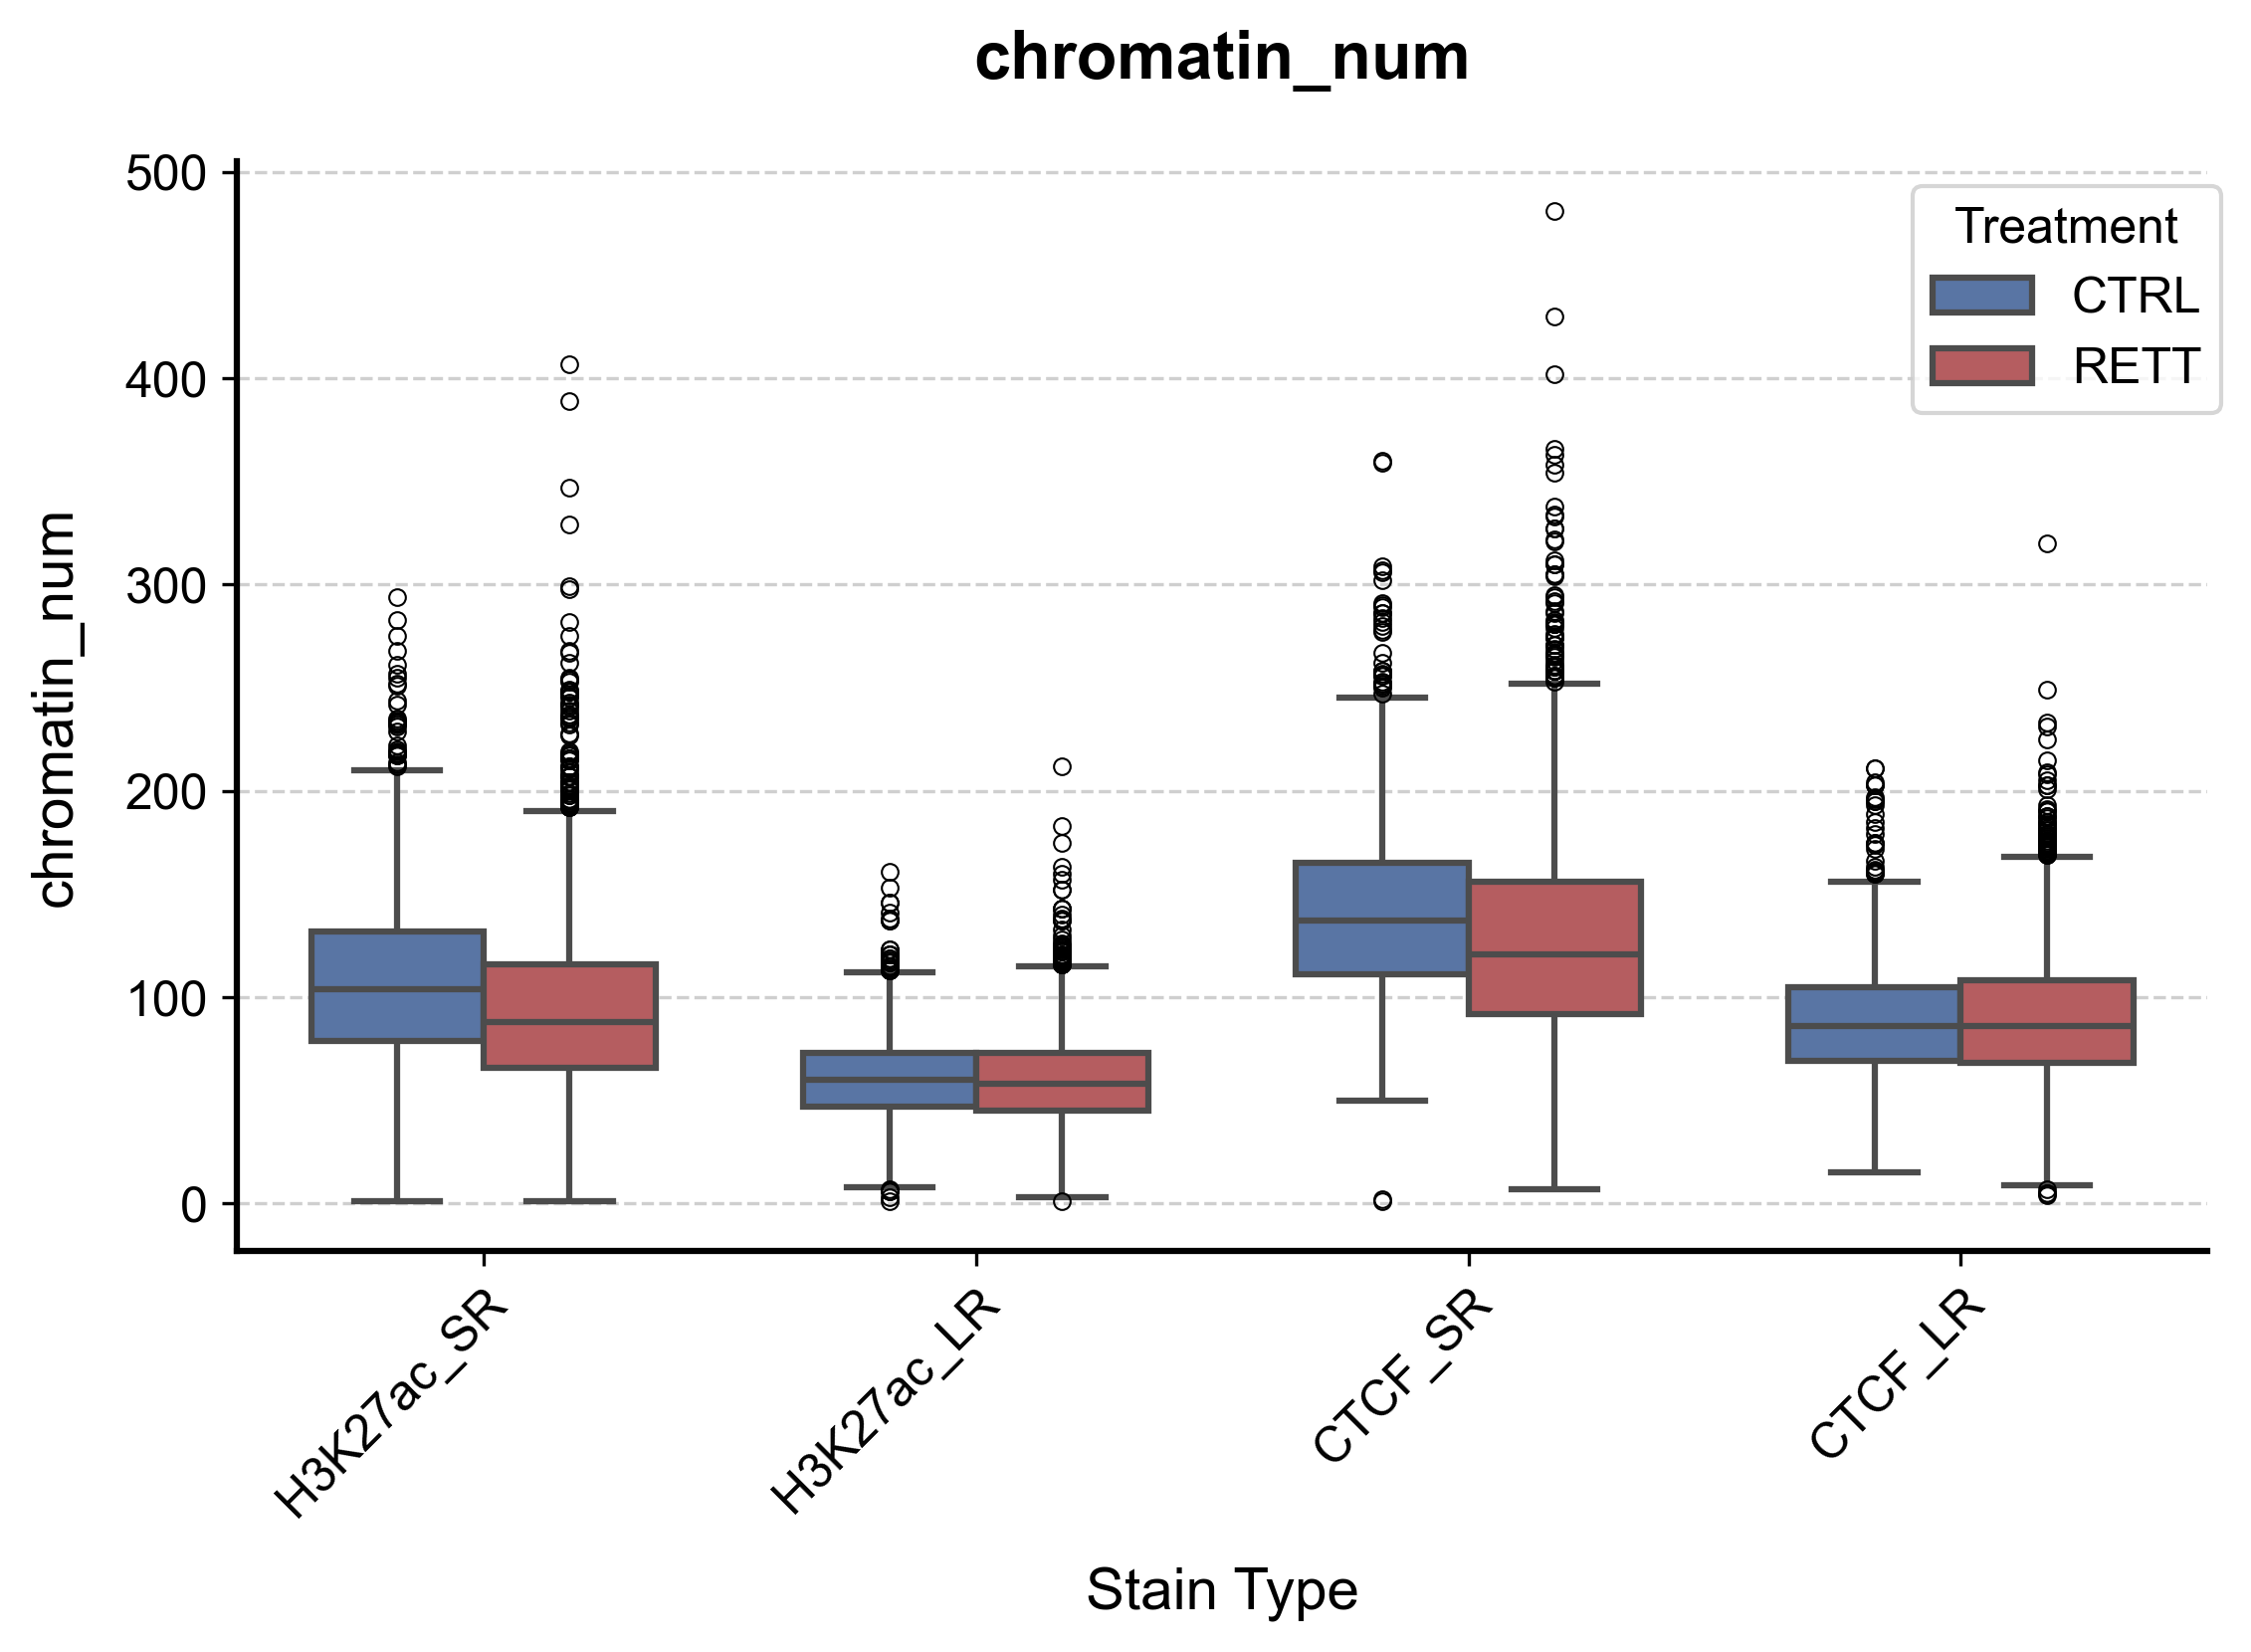

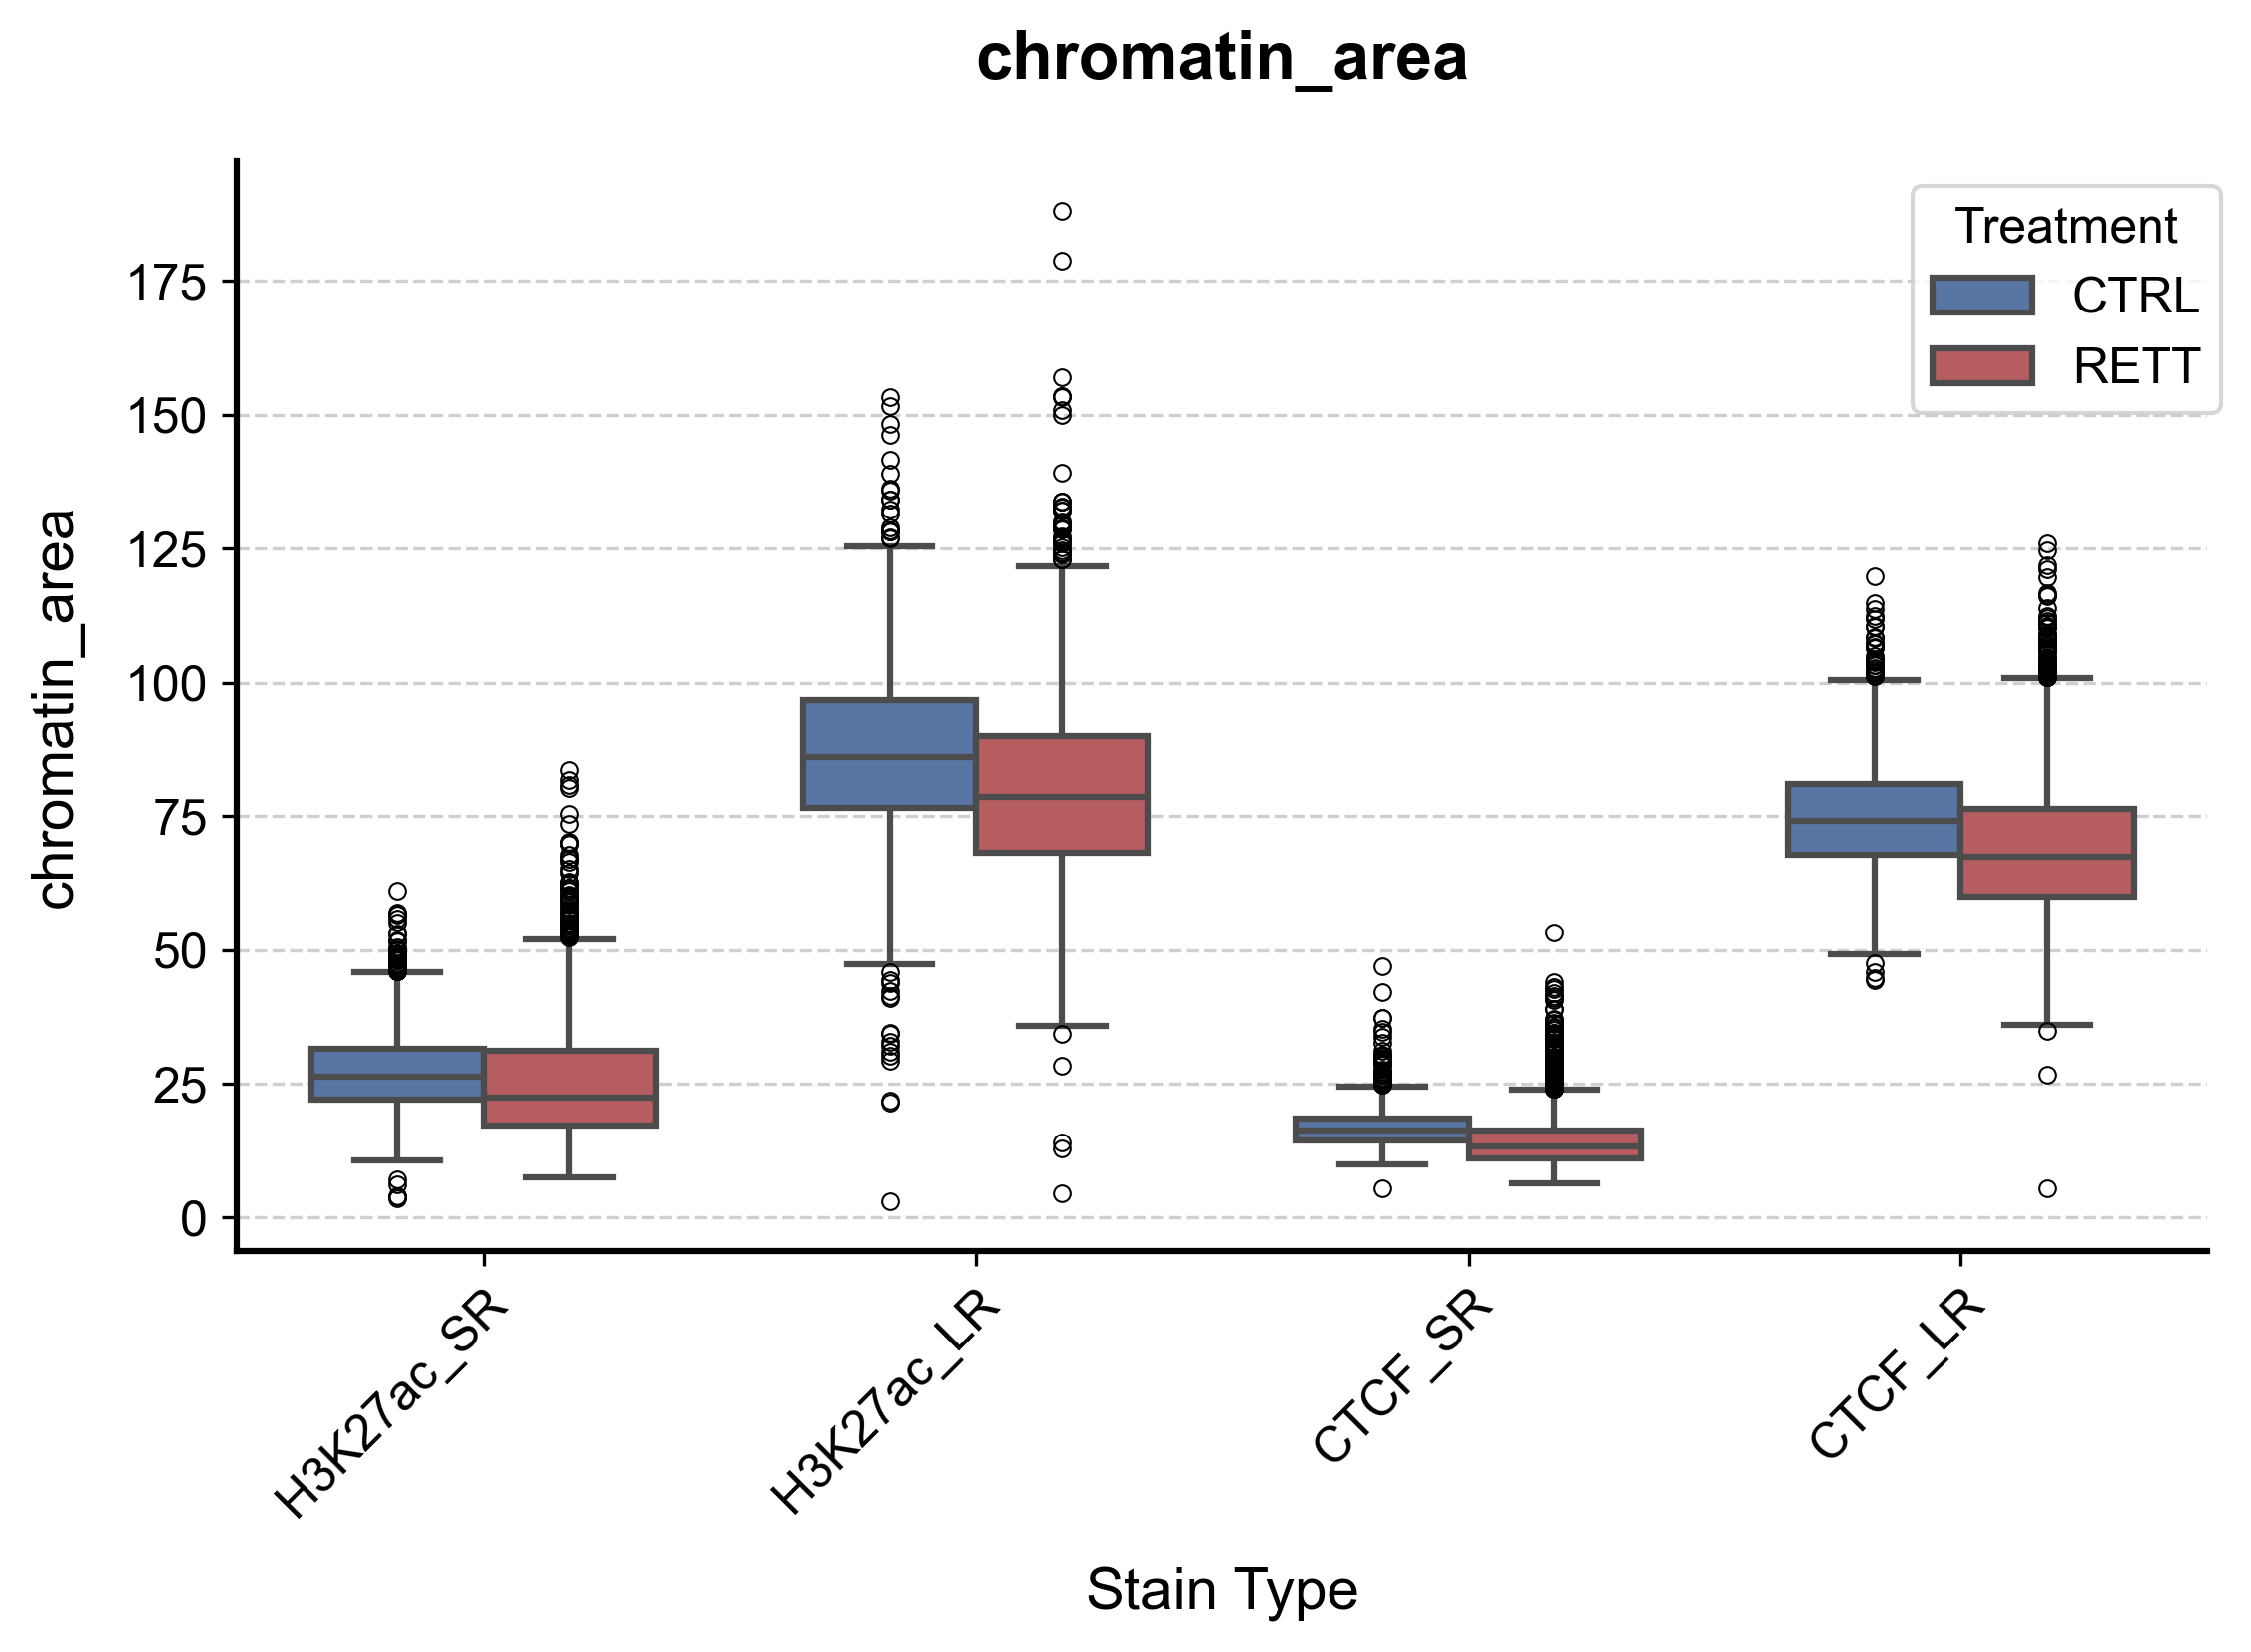

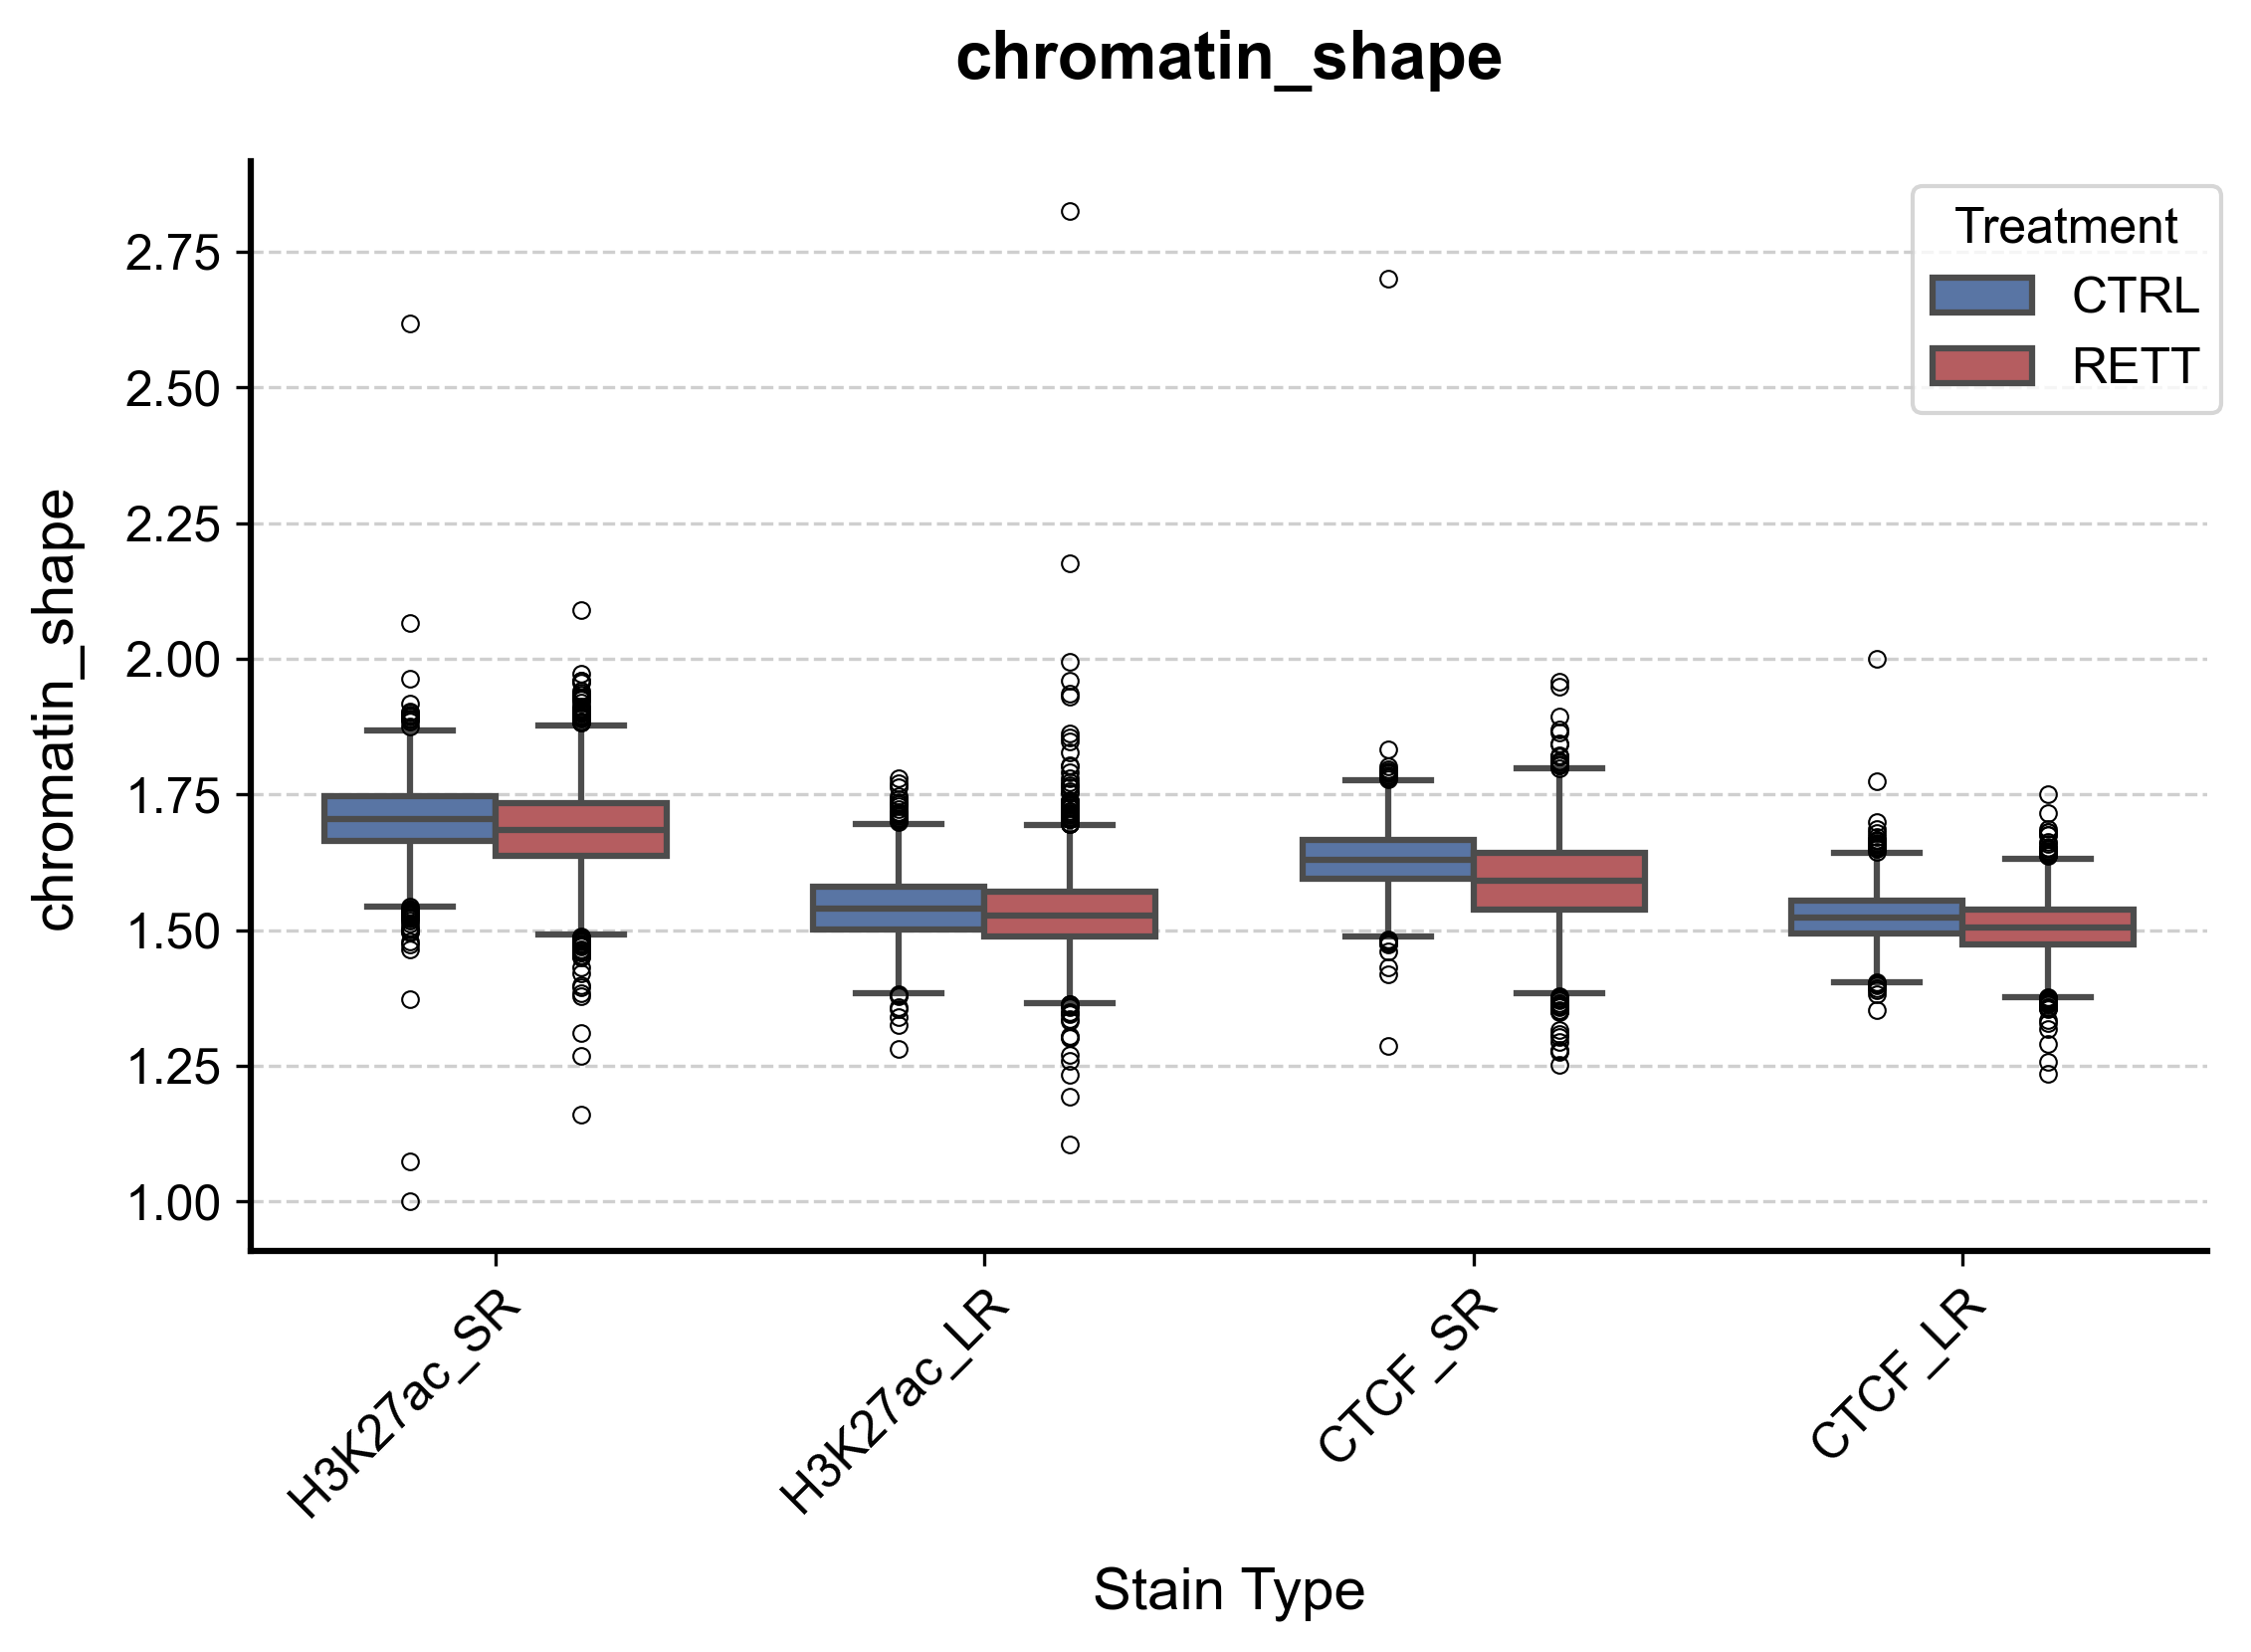

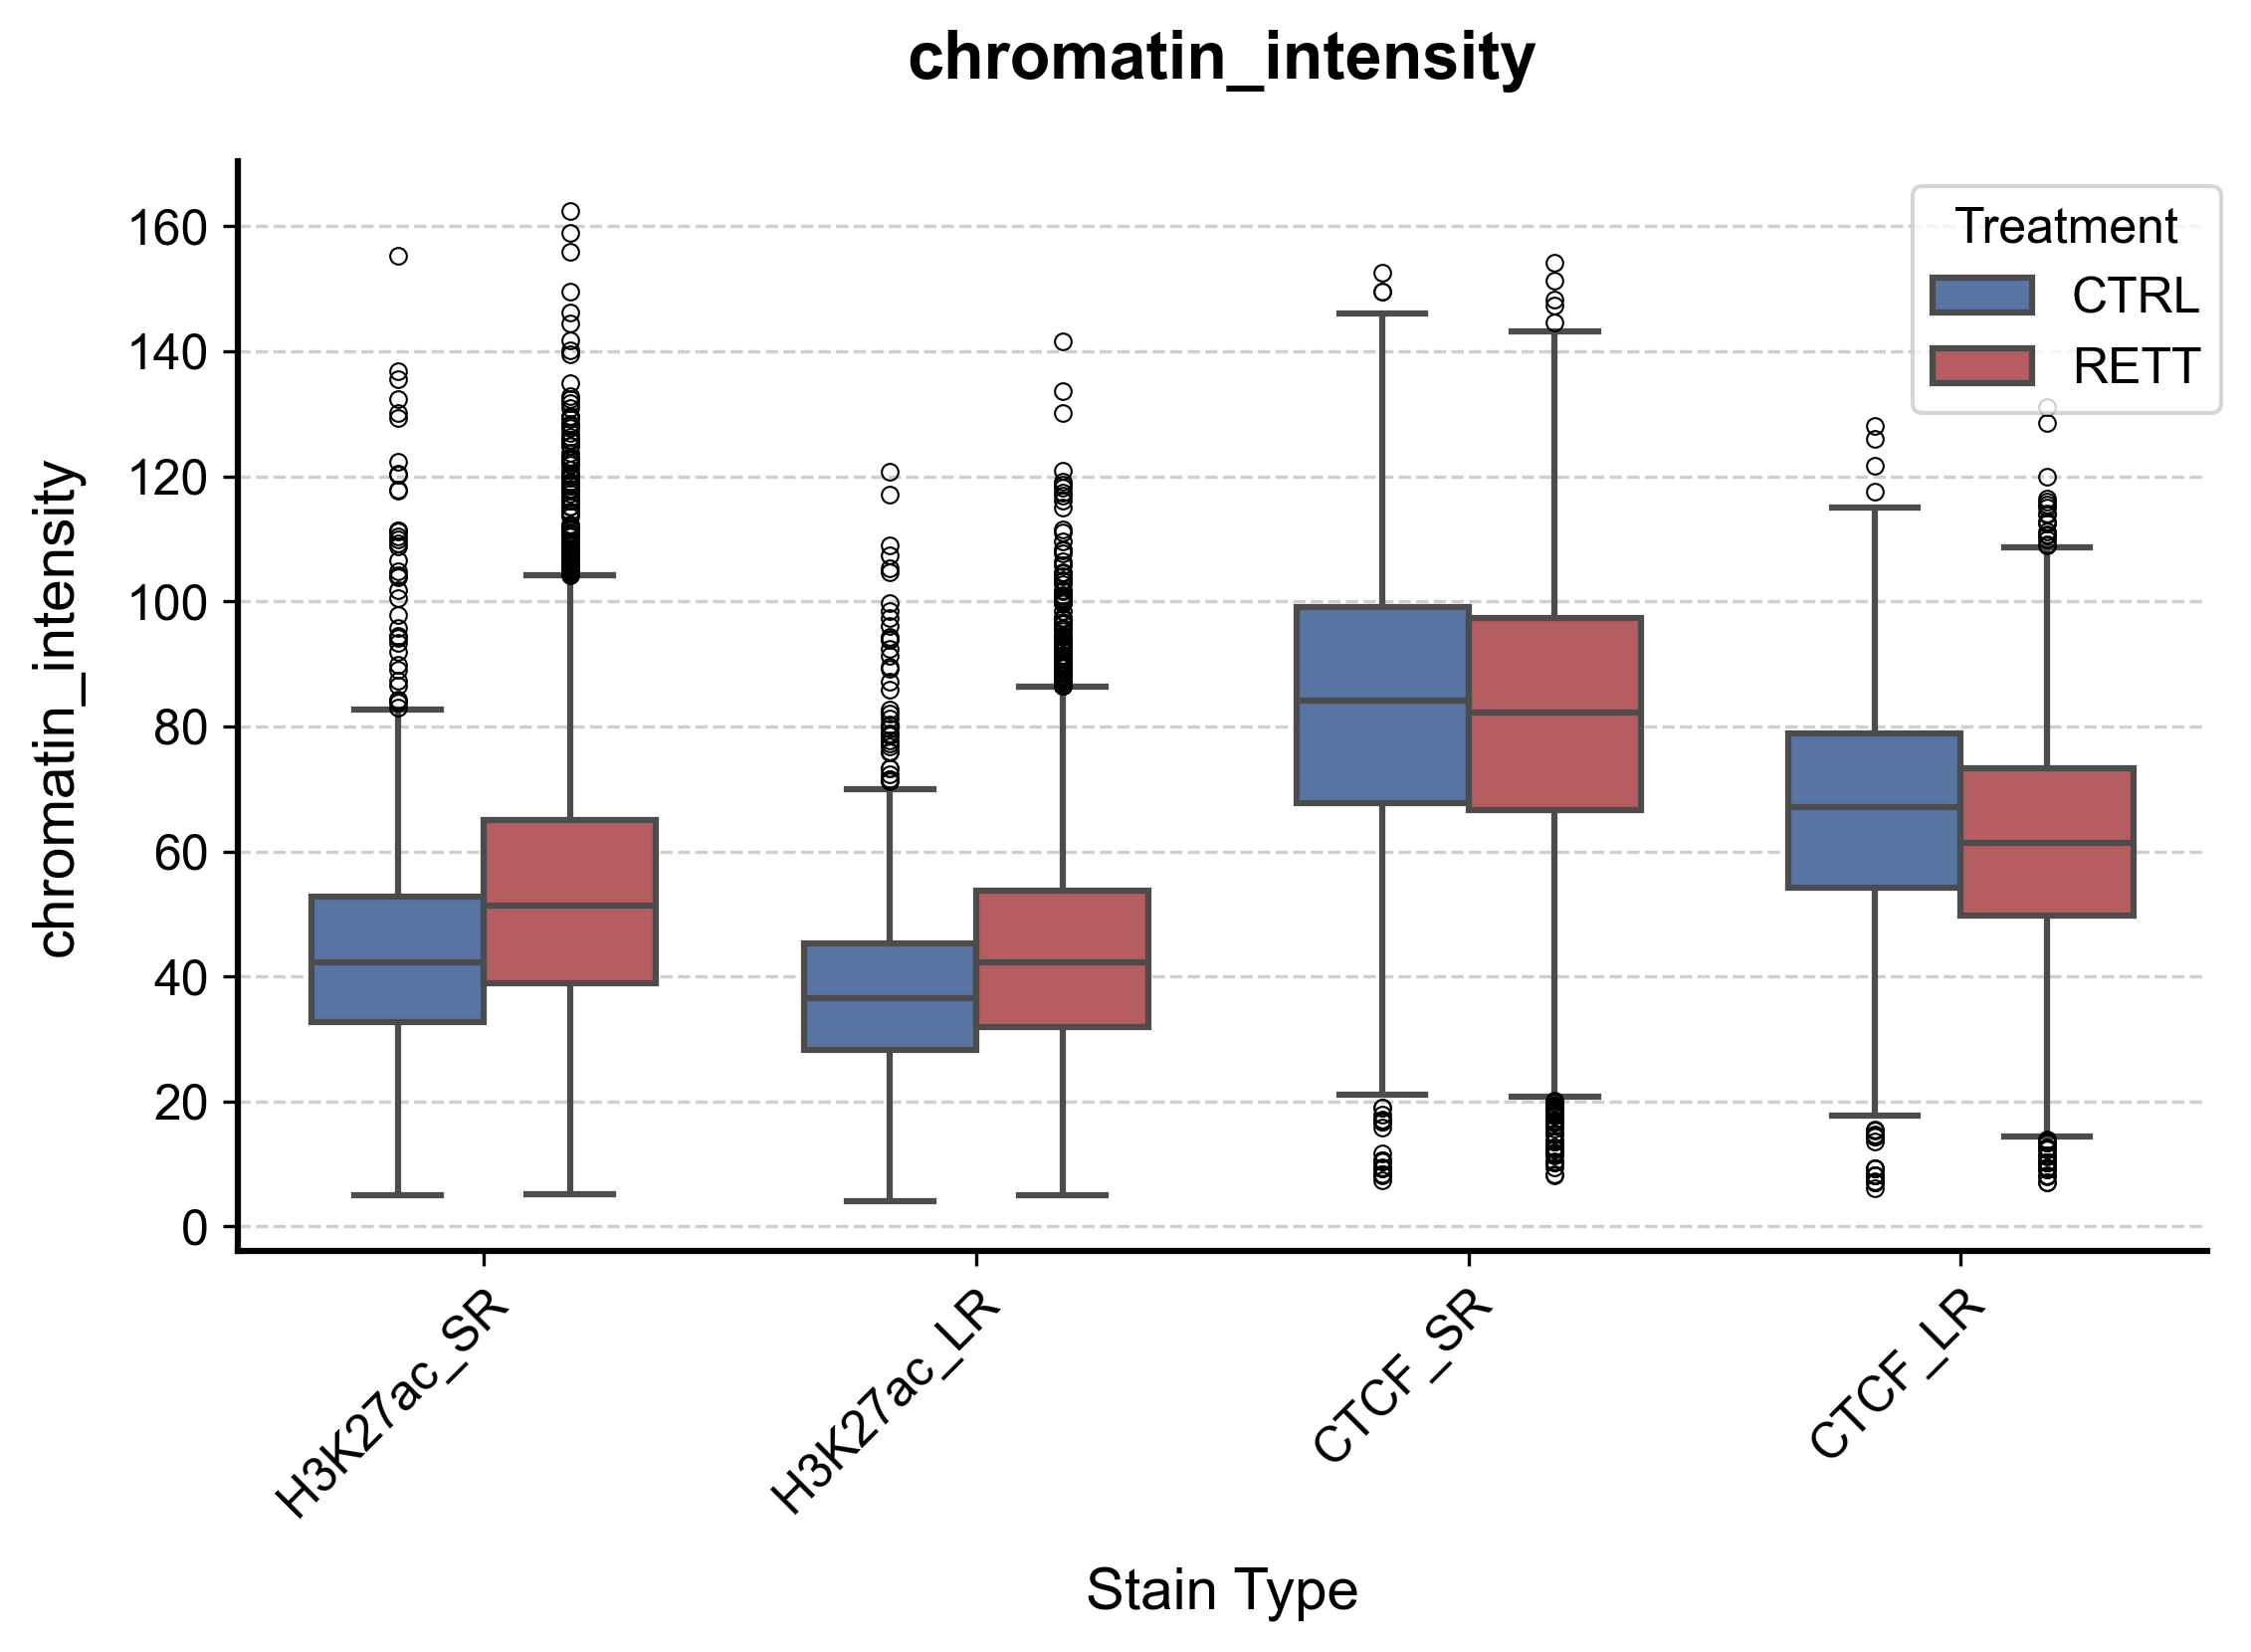

In [75]:
savepath = f"{homepath}/results_RTT/Biomarker/results_figures"

title={'chromatin_num':  'Chromatin number',
       'chromatin_area': 'Chromatin area',
       'chromatin_shape':'Chromatin shape',
       'chromatin_intensity':'Chromatin intensity',
       'chromatin_distribution_part5': 'Chromatin density in periphery'
      }

for feature in ['chromatin_num', 'chromatin_area', 'chromatin_shape', 'chromatin_intensity']:
    validata_boxplot(data_all, feature, savepath)

In [102]:
def chromatin_distribution_plot(data_all:pd.DataFrame, stain_type:str, savepath:str, rett="RETT") -> None:

    # --------------------------- ① 组装长格式 ---------------------------
    rows = []
    for part in range(1, 6):
        for state in ("CTRL", rett):
            col = f"chromatin_distribution_part{part}"
            series = (
                data_all.loc[
                    (data_all["State"] == state)
                    & (data_all["Stain_Type"] == stain_type),
                    col,
                ]
                .dropna()
                .values
            )
            rows.extend(
                [
                    {"Part": f"Part {part}", "State": state, "Value": v}
                    for v in series
                ]
            )
    plot_df = pd.DataFrame(rows)

    # --------------------------- ② 基本图形 ---------------------------
    sns.set_theme(style="whitegrid", font_scale=1.1)

    palette = {"CTRL": "#1f77b4", rett: "#ff7f0e"}  # 只需给 hue 映射两色

    plt.figure(figsize=(10, 6))

    # 半透明小提琴
    sns.violinplot(
        data=plot_df,
        x="Part",
        y="Value",
        hue="State",
        palette=palette,
        dodge=True,
        inner=None,
        linewidth=1,
        alpha=0.35,
        density_norm="width",  # 取代旧 scale="width"
    )

    # 叠加箱线
    sns.boxplot(
        data=plot_df,
        x="Part",
        y="Value",
        hue="State",
        palette=palette,
        dodge=True,
        width=0.25,
        fliersize=1,
        saturation=0.6,
        showcaps=True,
        boxprops=dict(alpha=0.6),
        medianprops=dict(color="black", linewidth=1.2),
    )

    # --------------------------- ③ 中位数折线 ---------------------------
    # seaborn dodge 计算：每个 Part 上，CTRL 在左、RETT 在右
    # 获取箱线艺术家以获得确切 x 坐标
    ax = plt.gca()
    parts = sorted(plot_df["Part"].unique())  # ['Part 1'...'Part 5']
    offset = 0.2                              # 默认 dodge 宽度 / 2

    med_ctrl = []
    med_rett = []

    for xi, part in enumerate(parts):
        sub = plot_df[plot_df["Part"] == part]
        med_ctrl.append(sub[sub["State"] == "CTRL"]["Value"].median())
        med_rett.append(sub[sub["State"] == rett]["Value"].median())

    # 画线
    ax.plot(
        [x - offset for x in range(len(parts))],
        med_ctrl,
        color=palette["CTRL"],
        marker="o",
        label="Median CTRL",
    )
    ax.plot(
        [x + offset for x in range(len(parts))],
        med_rett,
        color=palette[rett],
        marker="o",
        label=f"Median {rett}",
    )

    # --------------------------- ④ 美化 ---------------------------
    ax.set_ylabel("Normalized centroid count per area")
    ax.set_title(f"Chromatin distribution ({stain_type}) — CTRL vs {rett}")
    ax.legend(loc="upper right")
    ax.set_xlabel("")  # Part 已在 x-tick
    plt.tight_layout()
    plt.savefig(
        f'{savepath}/chromatin_distribution_{stain_type}.png',
        dpi=600,
        bbox_inches='tight',
        transparent=False
    )
    plt.show()

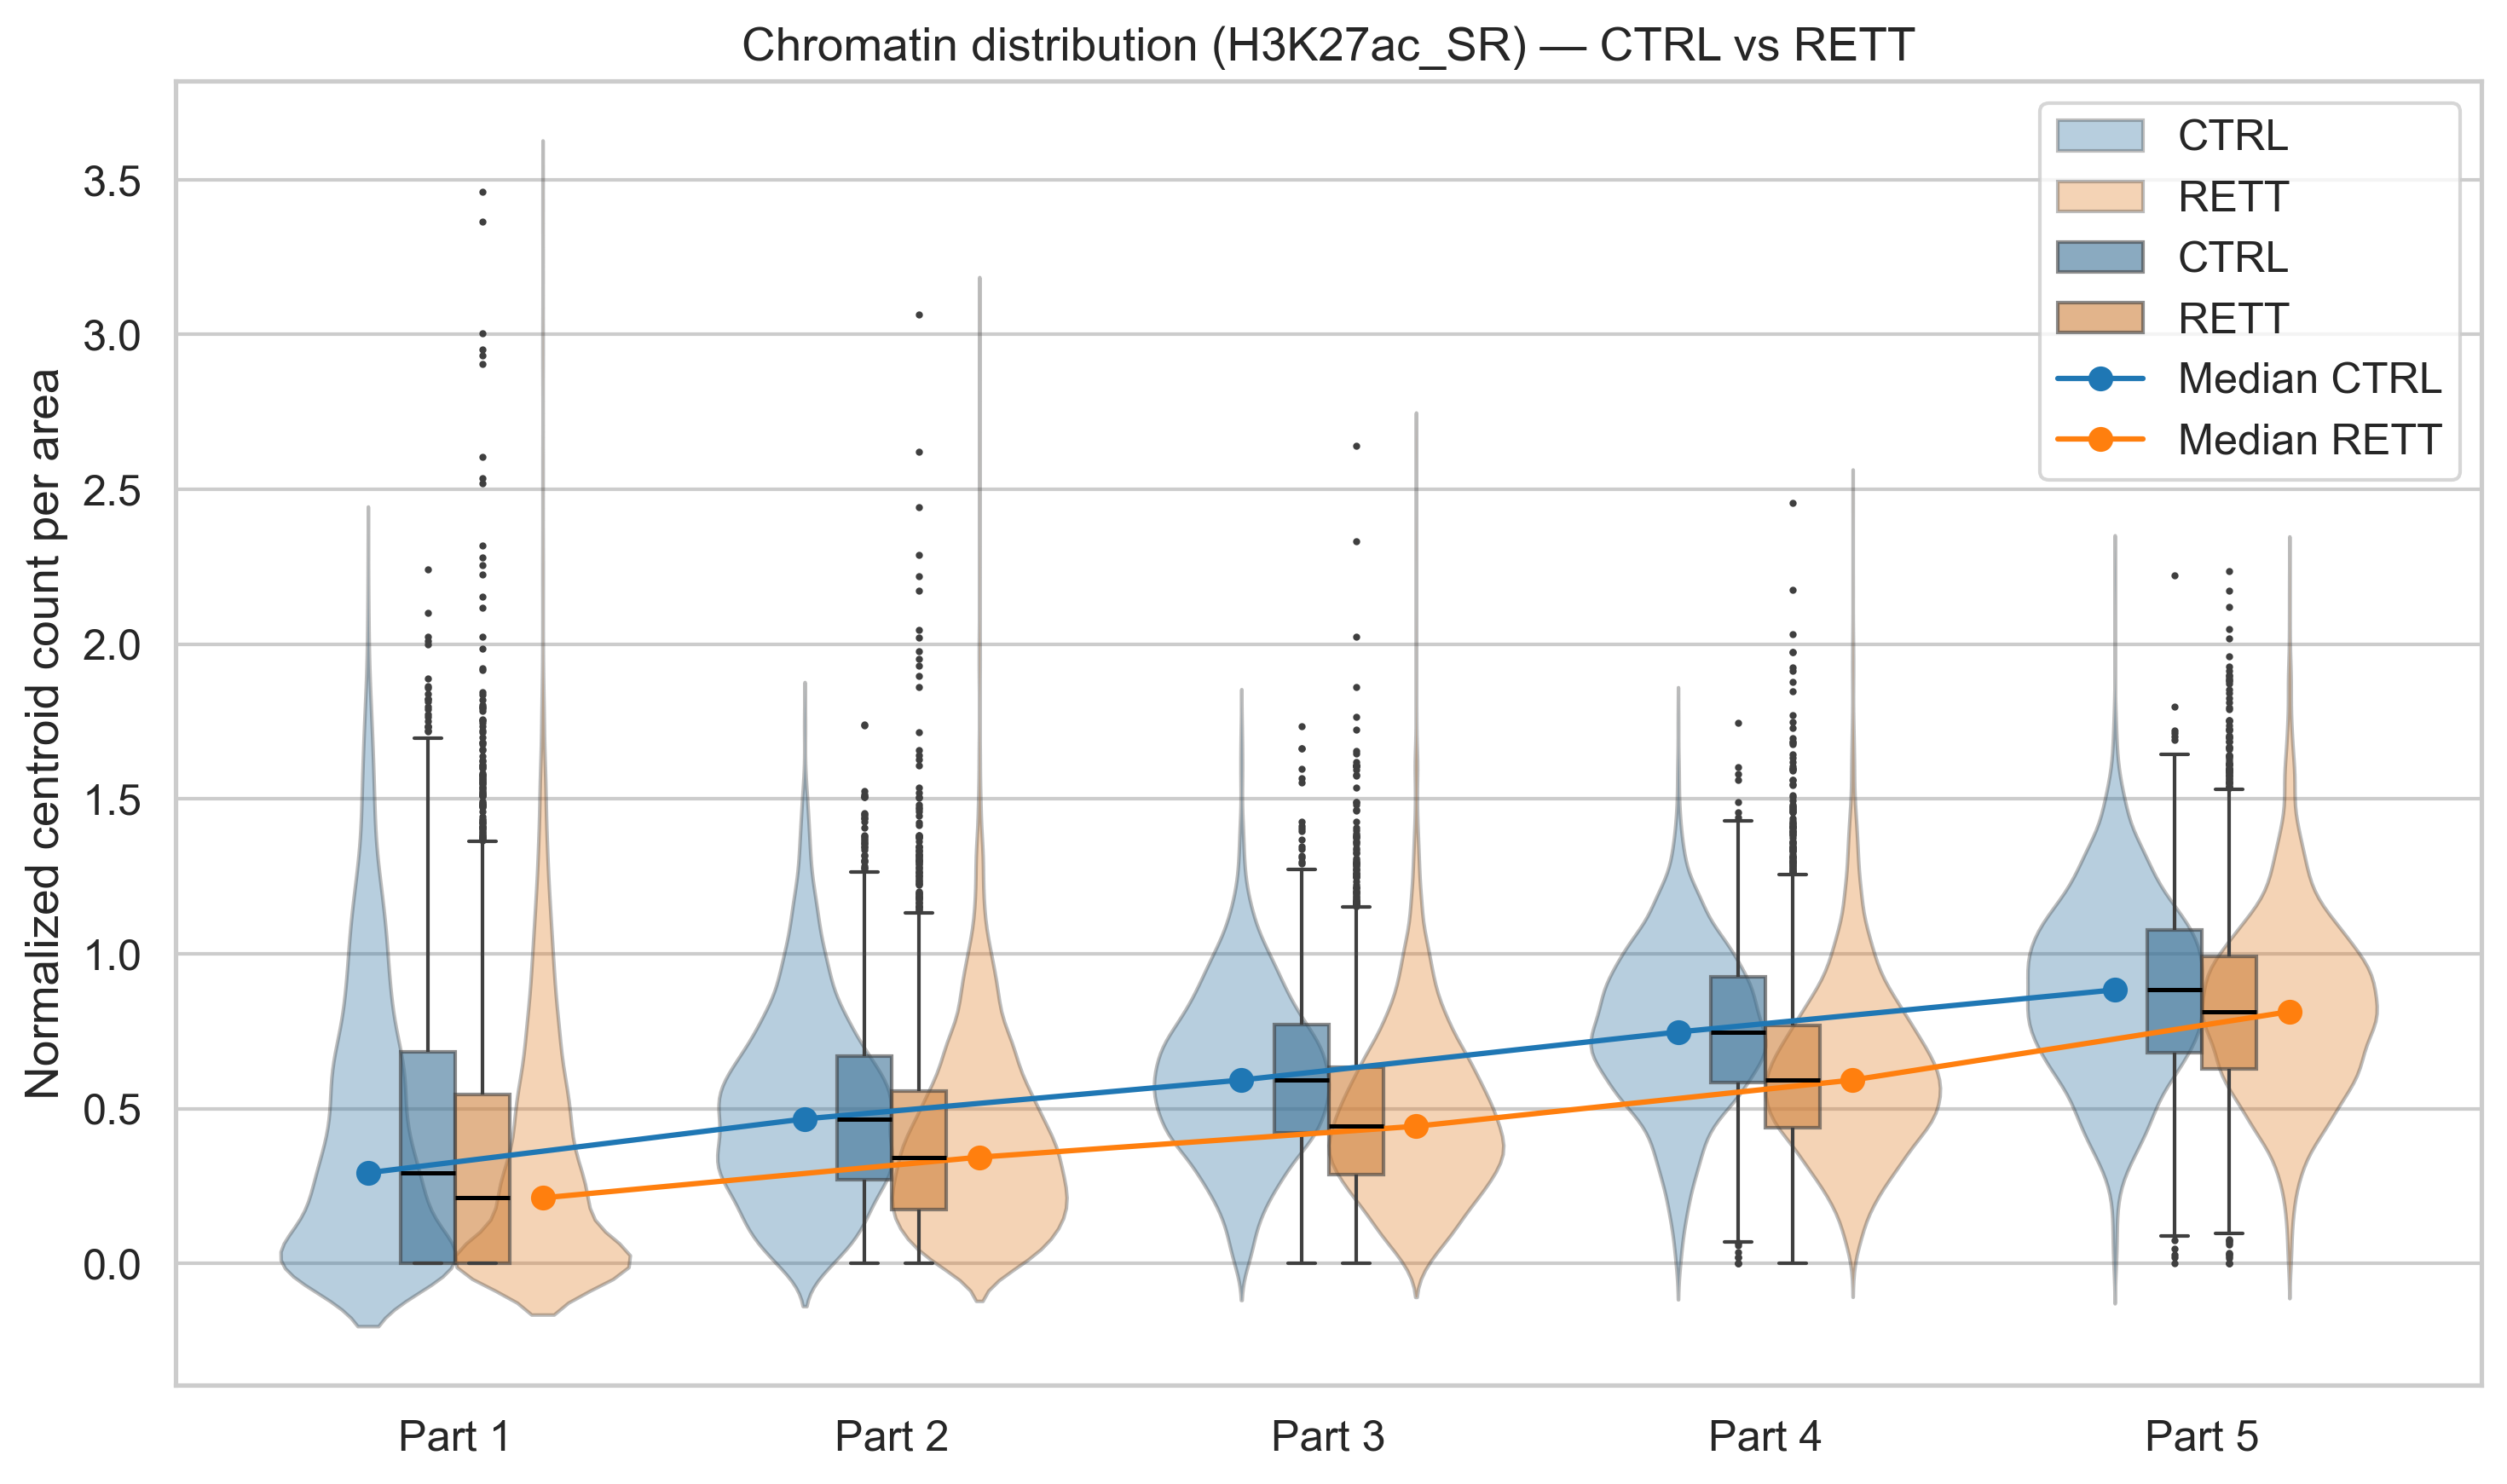

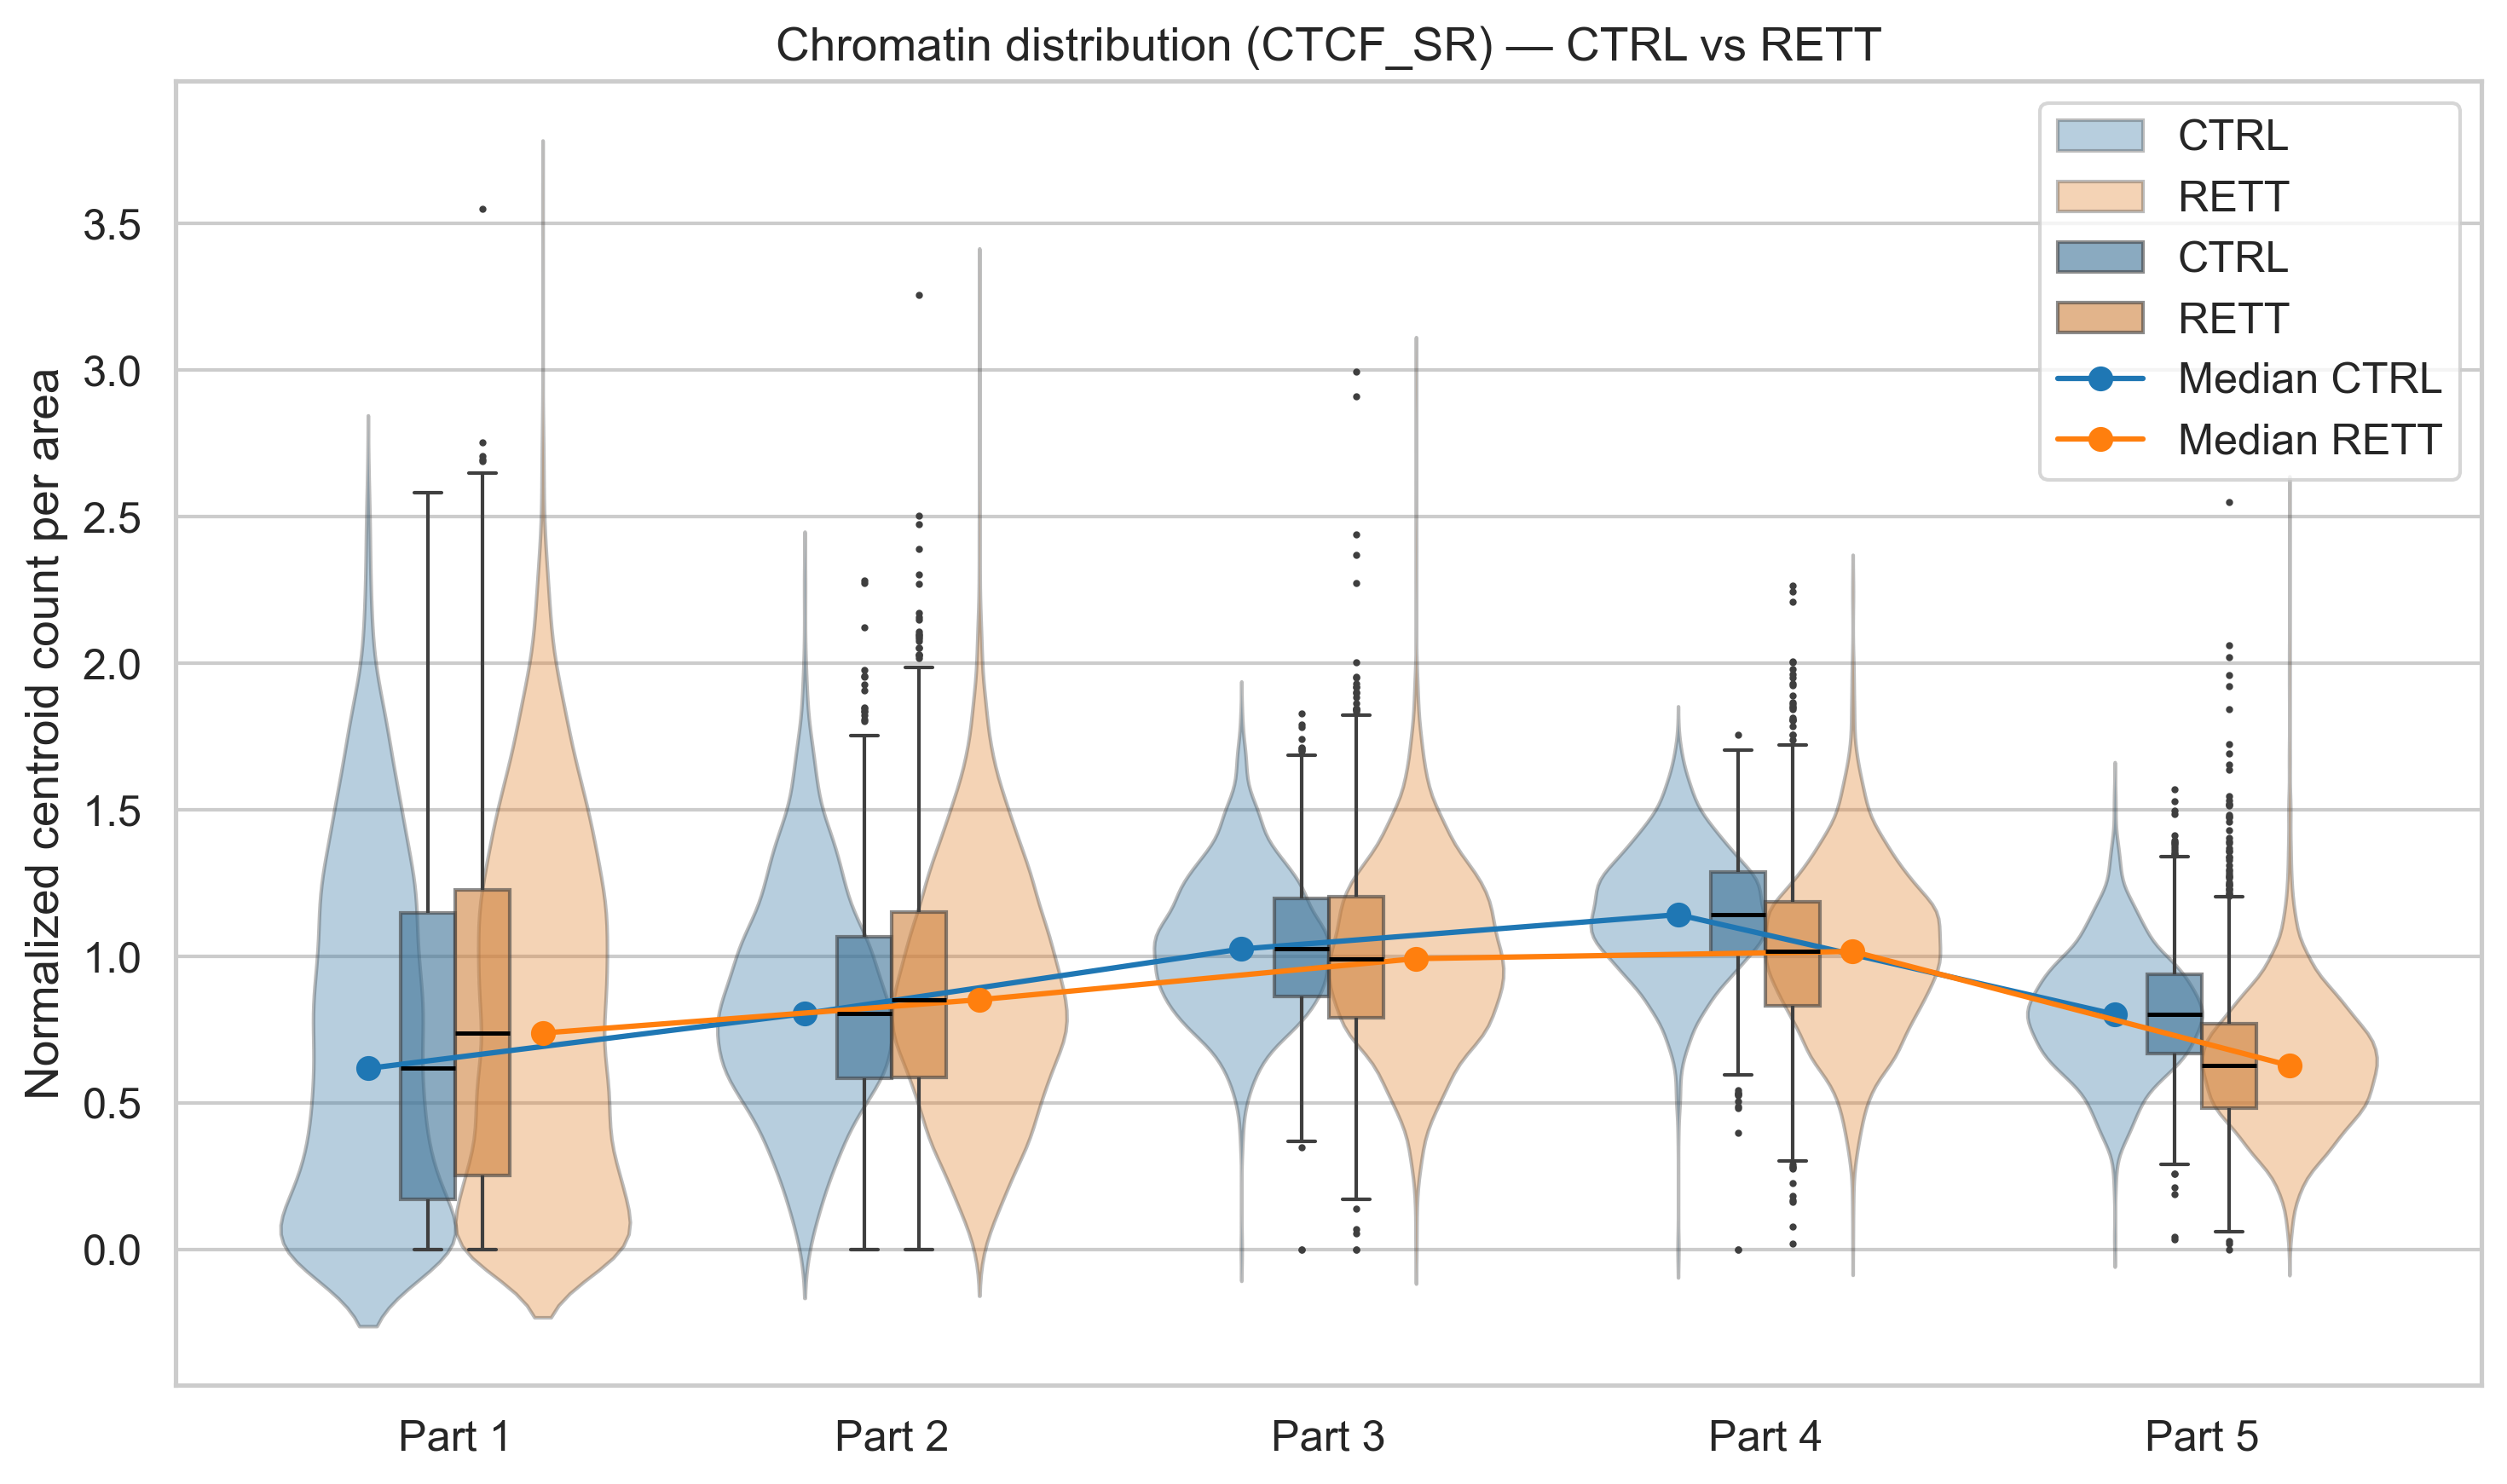

In [103]:
chromatin_distribution_plot(data_all, "H3K27ac_SR", savepath)
chromatin_distribution_plot(data_all, "CTCF_SR", savepath)

# BoxPlot for VPA

In [105]:
# 创建一个空的 DataFrame 用于存放所有数据
data_all = pd.DataFrame()
homepath = "/Users/Alpaca/Desktop/Github/disease_epigenome"

for stain_type in ["H3K27ac", "CTCF"]:
    loadpath = f"{homepath}/results_VPA/Biomarker/new_results"
    loadpath_VPA = f"{loadpath}/VPA_{stain_type}_basic.csv"
    loadpath_CTRL = f"{loadpath}/CTRL_{stain_type}_basic.csv"
    
    df_combined, df_VPA, df_CTRL = loadcsv(loadpath_VPA, loadpath_CTRL, rett="VPA")
    
    df_combined['Stain_Type'] = f"{stain_type}"
    
    data_all = pd.concat([data_all, df_combined])

data_all.head(5)

,chromatin_num,chromatin_area,chromatin_intensity,chromatin_shape,nuclear_area,nuclear_intensity,chromatin_distribution_part1,chromatin_distribution_part2,chromatin_distribution_part3,chromatin_distribution_part4,chromatin_distribution_part5,RCA-S,RCA-M,RCI-S,RCI-M,State,Stain_Type
0,1,80.000000,163.699997,1.052944,47966.0,31.118917,0.000000,0.000000,0.026061,0.000000,0.000000,0.001668,0.001668,5.260466,5.260466,CTRL,H3K27ac
1,131,34.465649,74.582892,1.499350,177832.0,31.759880,0.105426,0.164134,0.196640,0.200953,0.179595,0.025389,0.000194,307.632110,2.348337,CTRL,H3K27ac
2,13,34.846154,69.886805,1.727972,61112.0,26.443350,0.000000,0.033986,0.061209,0.087535,0.034248,0.007413,0.000570,34.357541,2.642888,CTRL,H3K27ac
3,103,30.813725,83.928369,1.417492,136663.0,37.974594,0.045679,0.183050,0.173700,0.202667,0.198110,0.022998,0.000225,225.432131,2.210119,CTRL,H3K27ac
4,7,62.714286,142.854448,1.235951,81667.0,23.281301,0.000000,0.076445,0.015310,0.010905,0.017029,0.005375,0.000768,42.952115,6.136016,CTRL,H3K27ac


In [106]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

def validata_boxplot(data_all, feature, savepath, rett="VPA", ylim=None):
    matplotlib.style.use('default')
    plt.rcParams.update({
        'font.family': 'sans-serif',          # 指定为无衬线字体族
        'font.sans-serif': ['Arial'],         # 只保留 Arial（禁用其他字体回退）
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'axes.linewidth': 1.5,
        'pdf.fonttype': 42,
        'figure.dpi': 300,
    })
    
    # 数据清洗
    data_all = data_all.dropna(subset=[feature])
    unique_stains = ['H3K27ac', 'CTCF']
    valid_stains = [stain for stain in unique_stains 
                    if set(data_all[data_all['Stain_Type'] == stain]['State'].unique()) >= {'CTRL', rett}]
    
    if not valid_stains:
        print(f"[Skip] No valid groups for feature: {feature}")
        return

    # 创建画布和坐标轴
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # 定义配色方案
    palette_colors = {"CTRL": "#4C72B0", rett: "#C44E52"}
    
    # 绘制箱线图
    sns.boxplot(
        x='Stain_Type',
        y=feature,
        hue='State',
        data=data_all[data_all['Stain_Type'].isin(valid_stains)],
        palette=palette_colors,
        order=valid_stains,
        width=0.7,
        linewidth=1.5,
        flierprops=dict(
            marker='o',
            markersize=4,
            markerfacecolor='none',
            markeredgecolor='black',
            markeredgewidth=0.5
        )
    )
    
    # 美化图形
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.6, axis='y')
    ax.set_title(f'{title[feature]}', fontweight='bold', pad=20)
    ax.set_ylabel(f'{title[feature]}', labelpad=10)
    ax.set_xlabel('Stain Type', labelpad=10)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, labels,
        loc='upper right',
        bbox_to_anchor=(1.02, 1),
        title='Cell State',
        title_fontsize=12
    )
    
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    if ylim is not None:
        plt.ylim(0, ylim)
    
    plt.tight_layout(pad=2.0)
    os.makedirs(savepath, exist_ok=True)
    plt.savefig(
        f'{savepath}/{feature}.png',
        dpi=600,
        bbox_inches='tight',
        transparent=False
    )
    plt.show()
    plt.close()

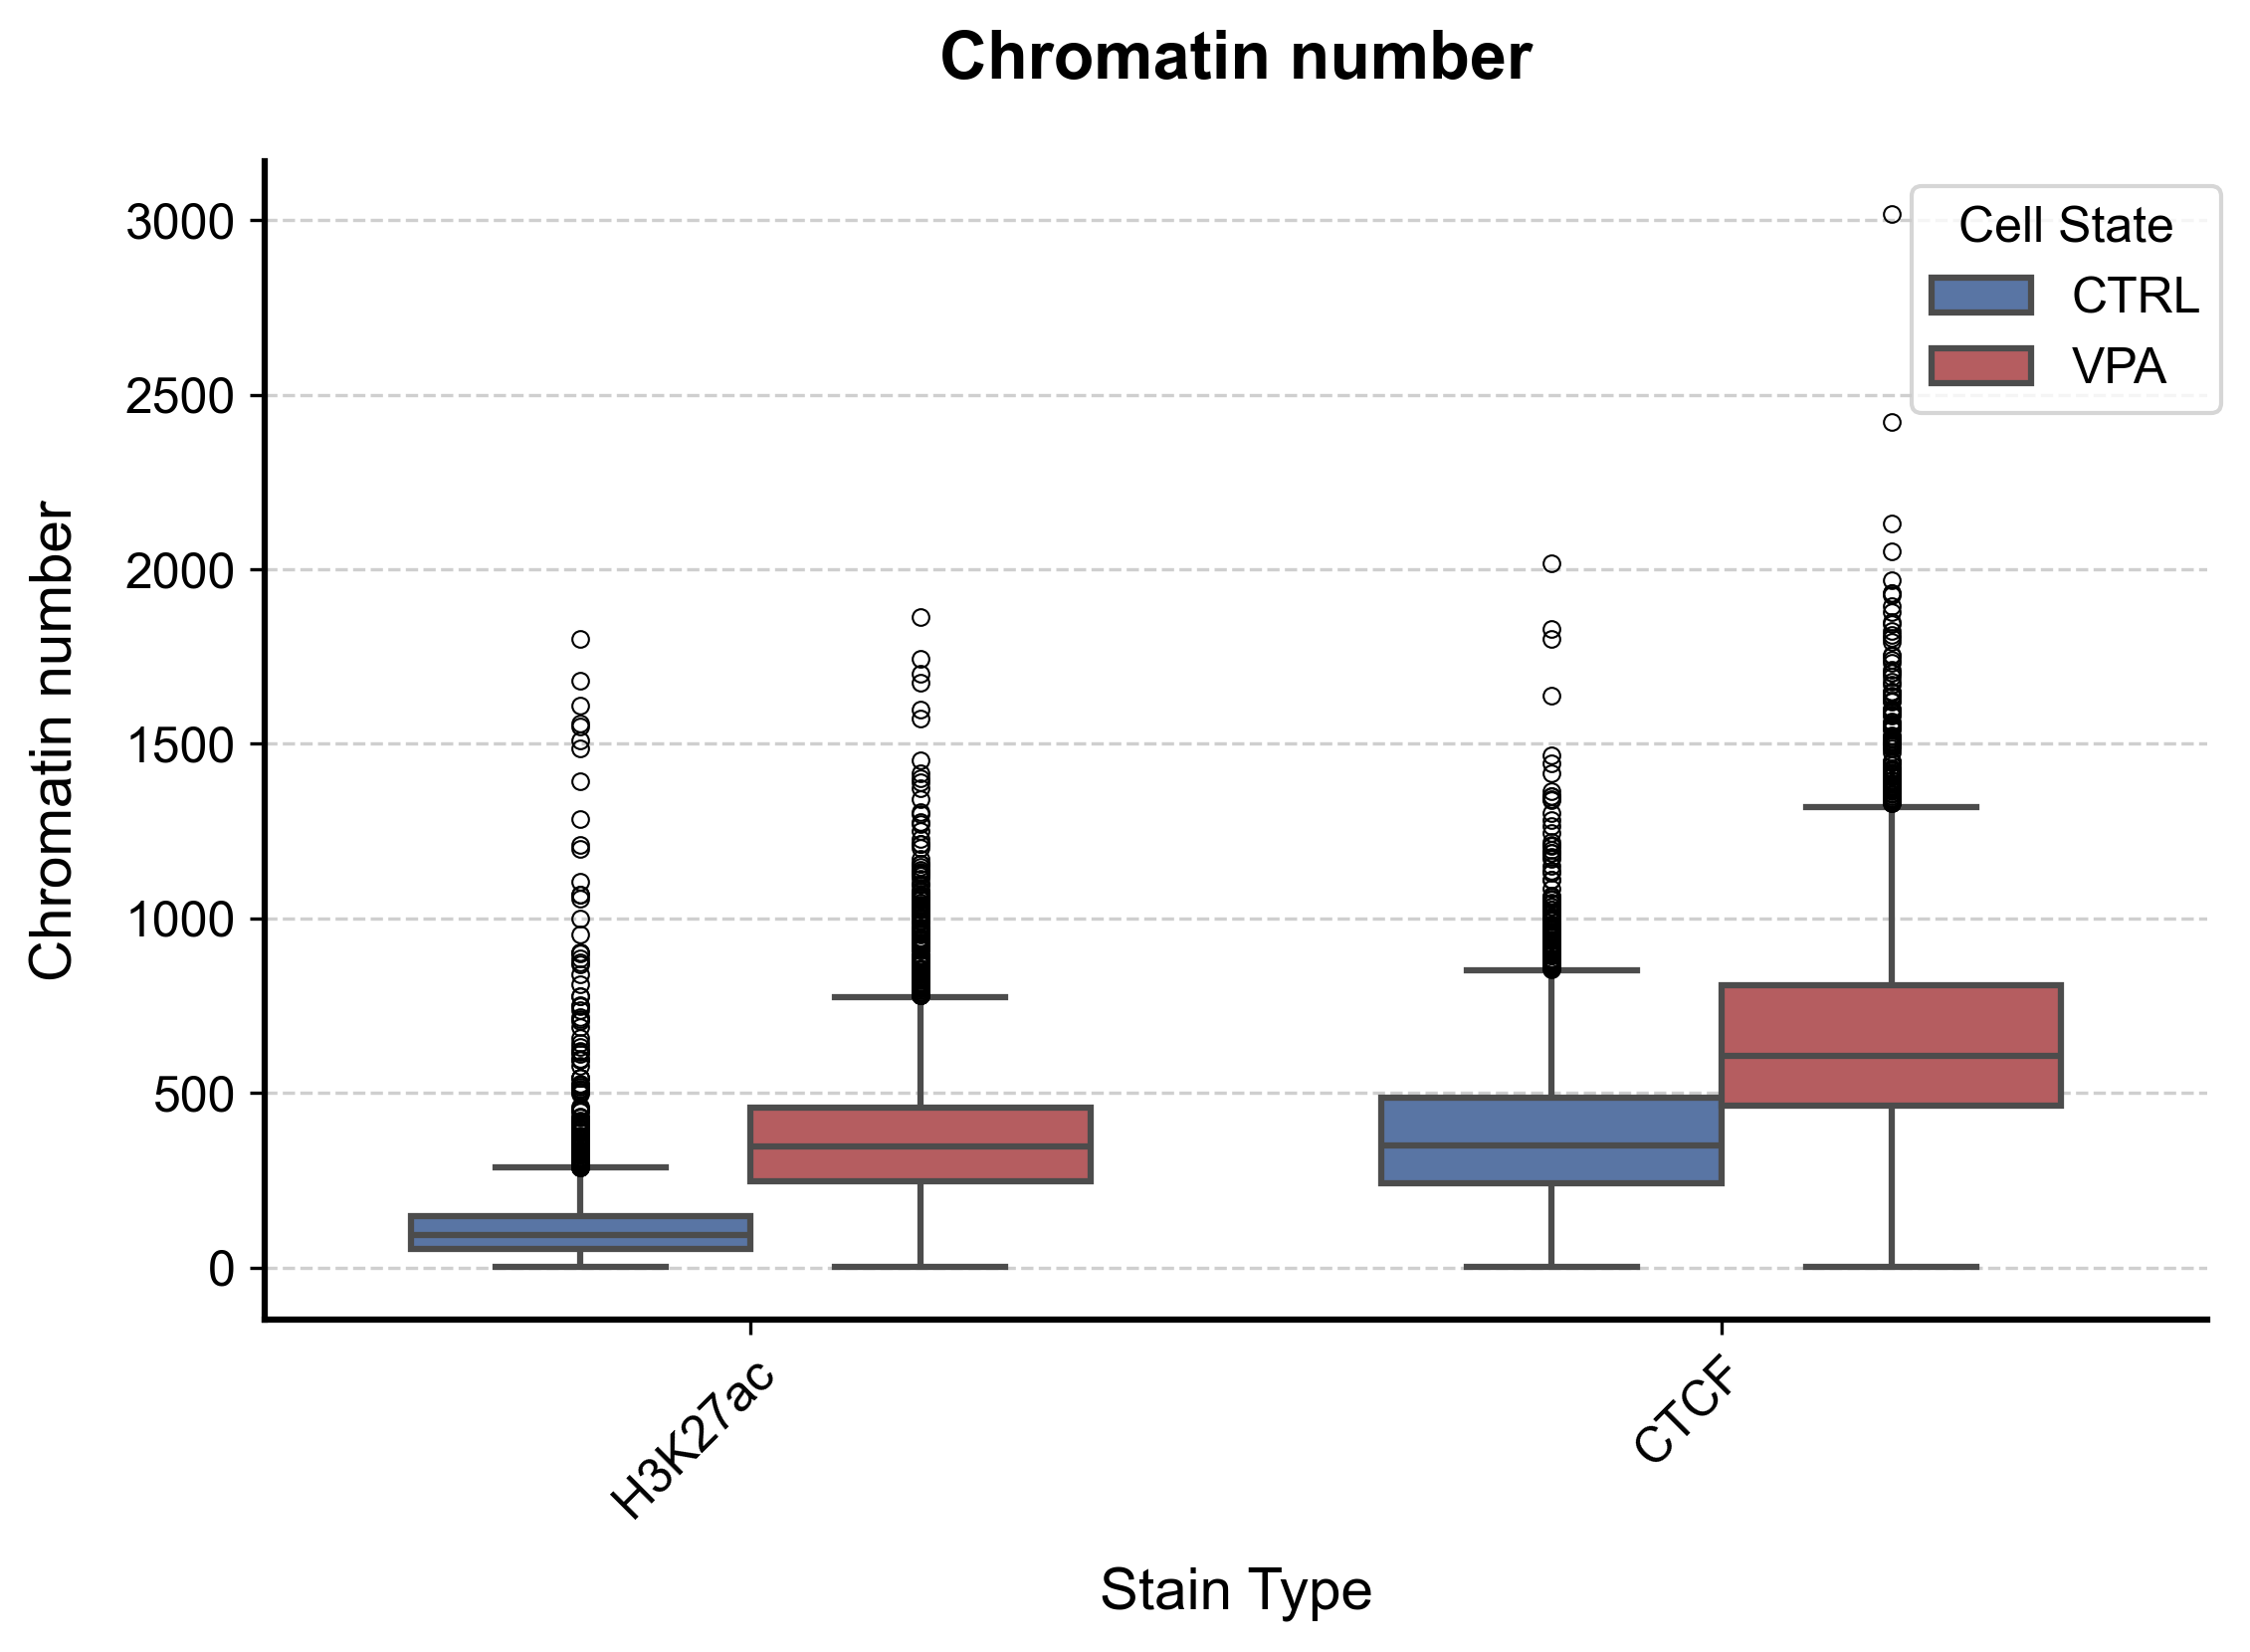

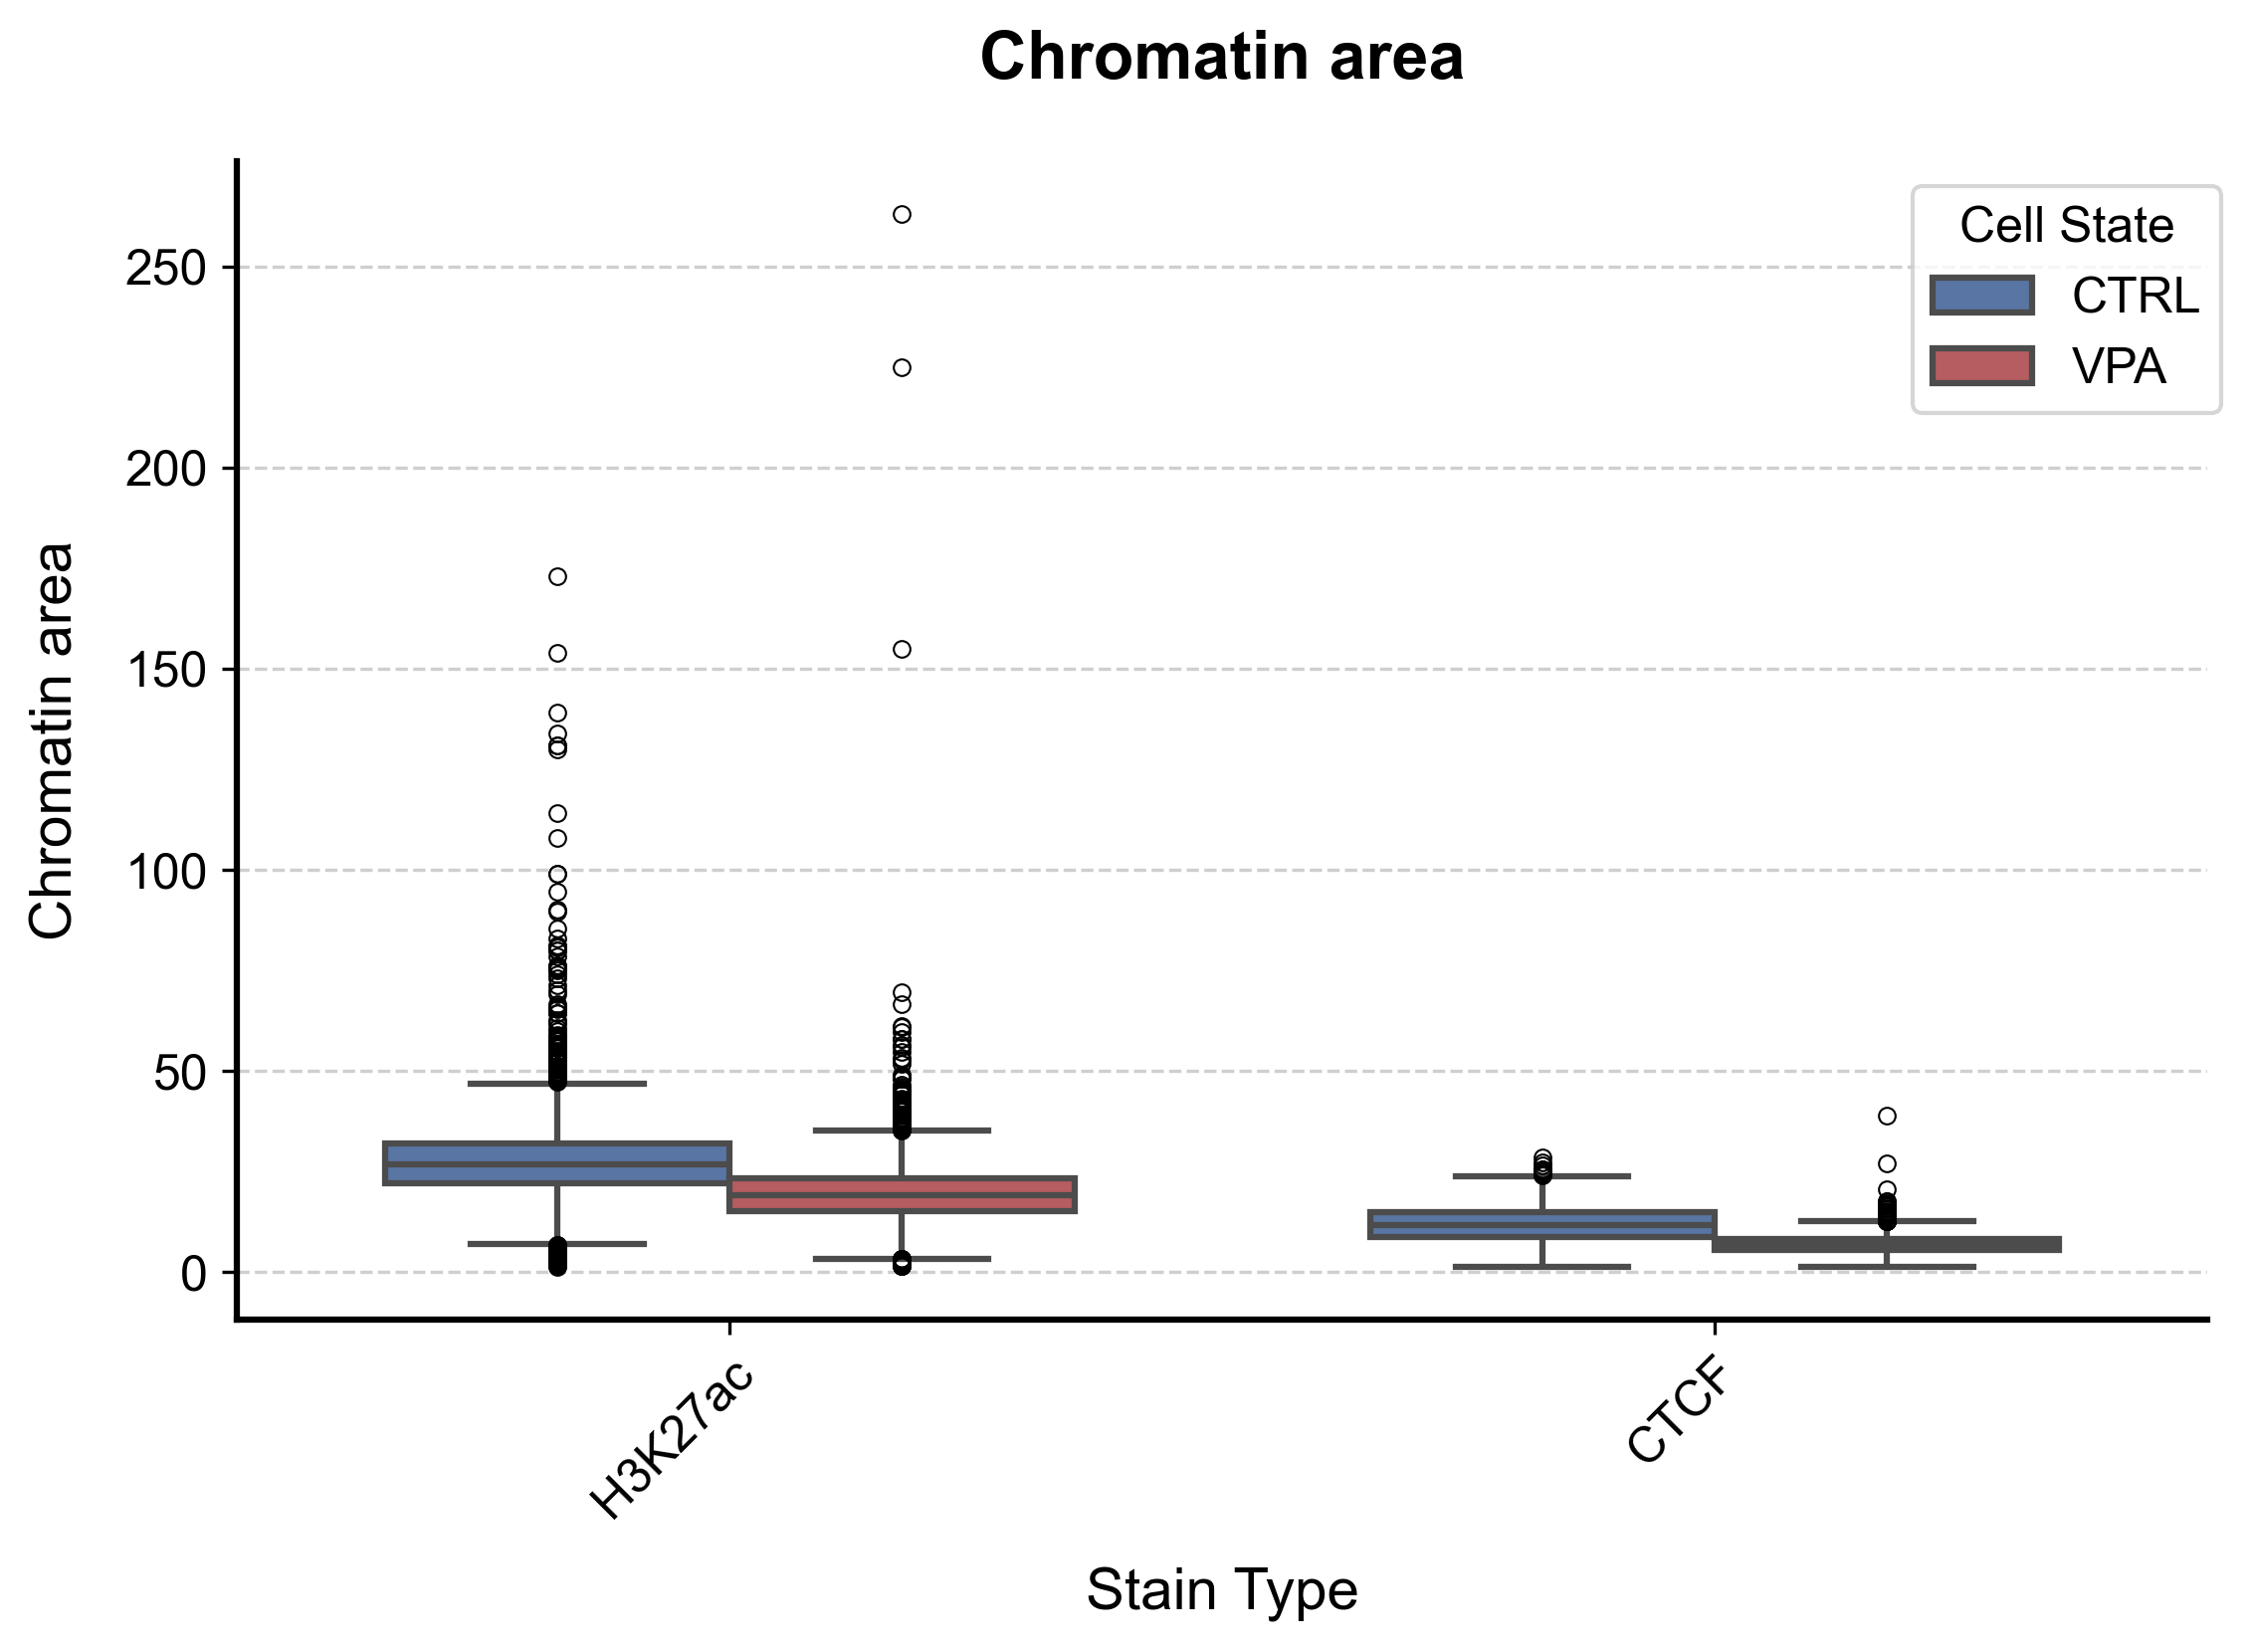

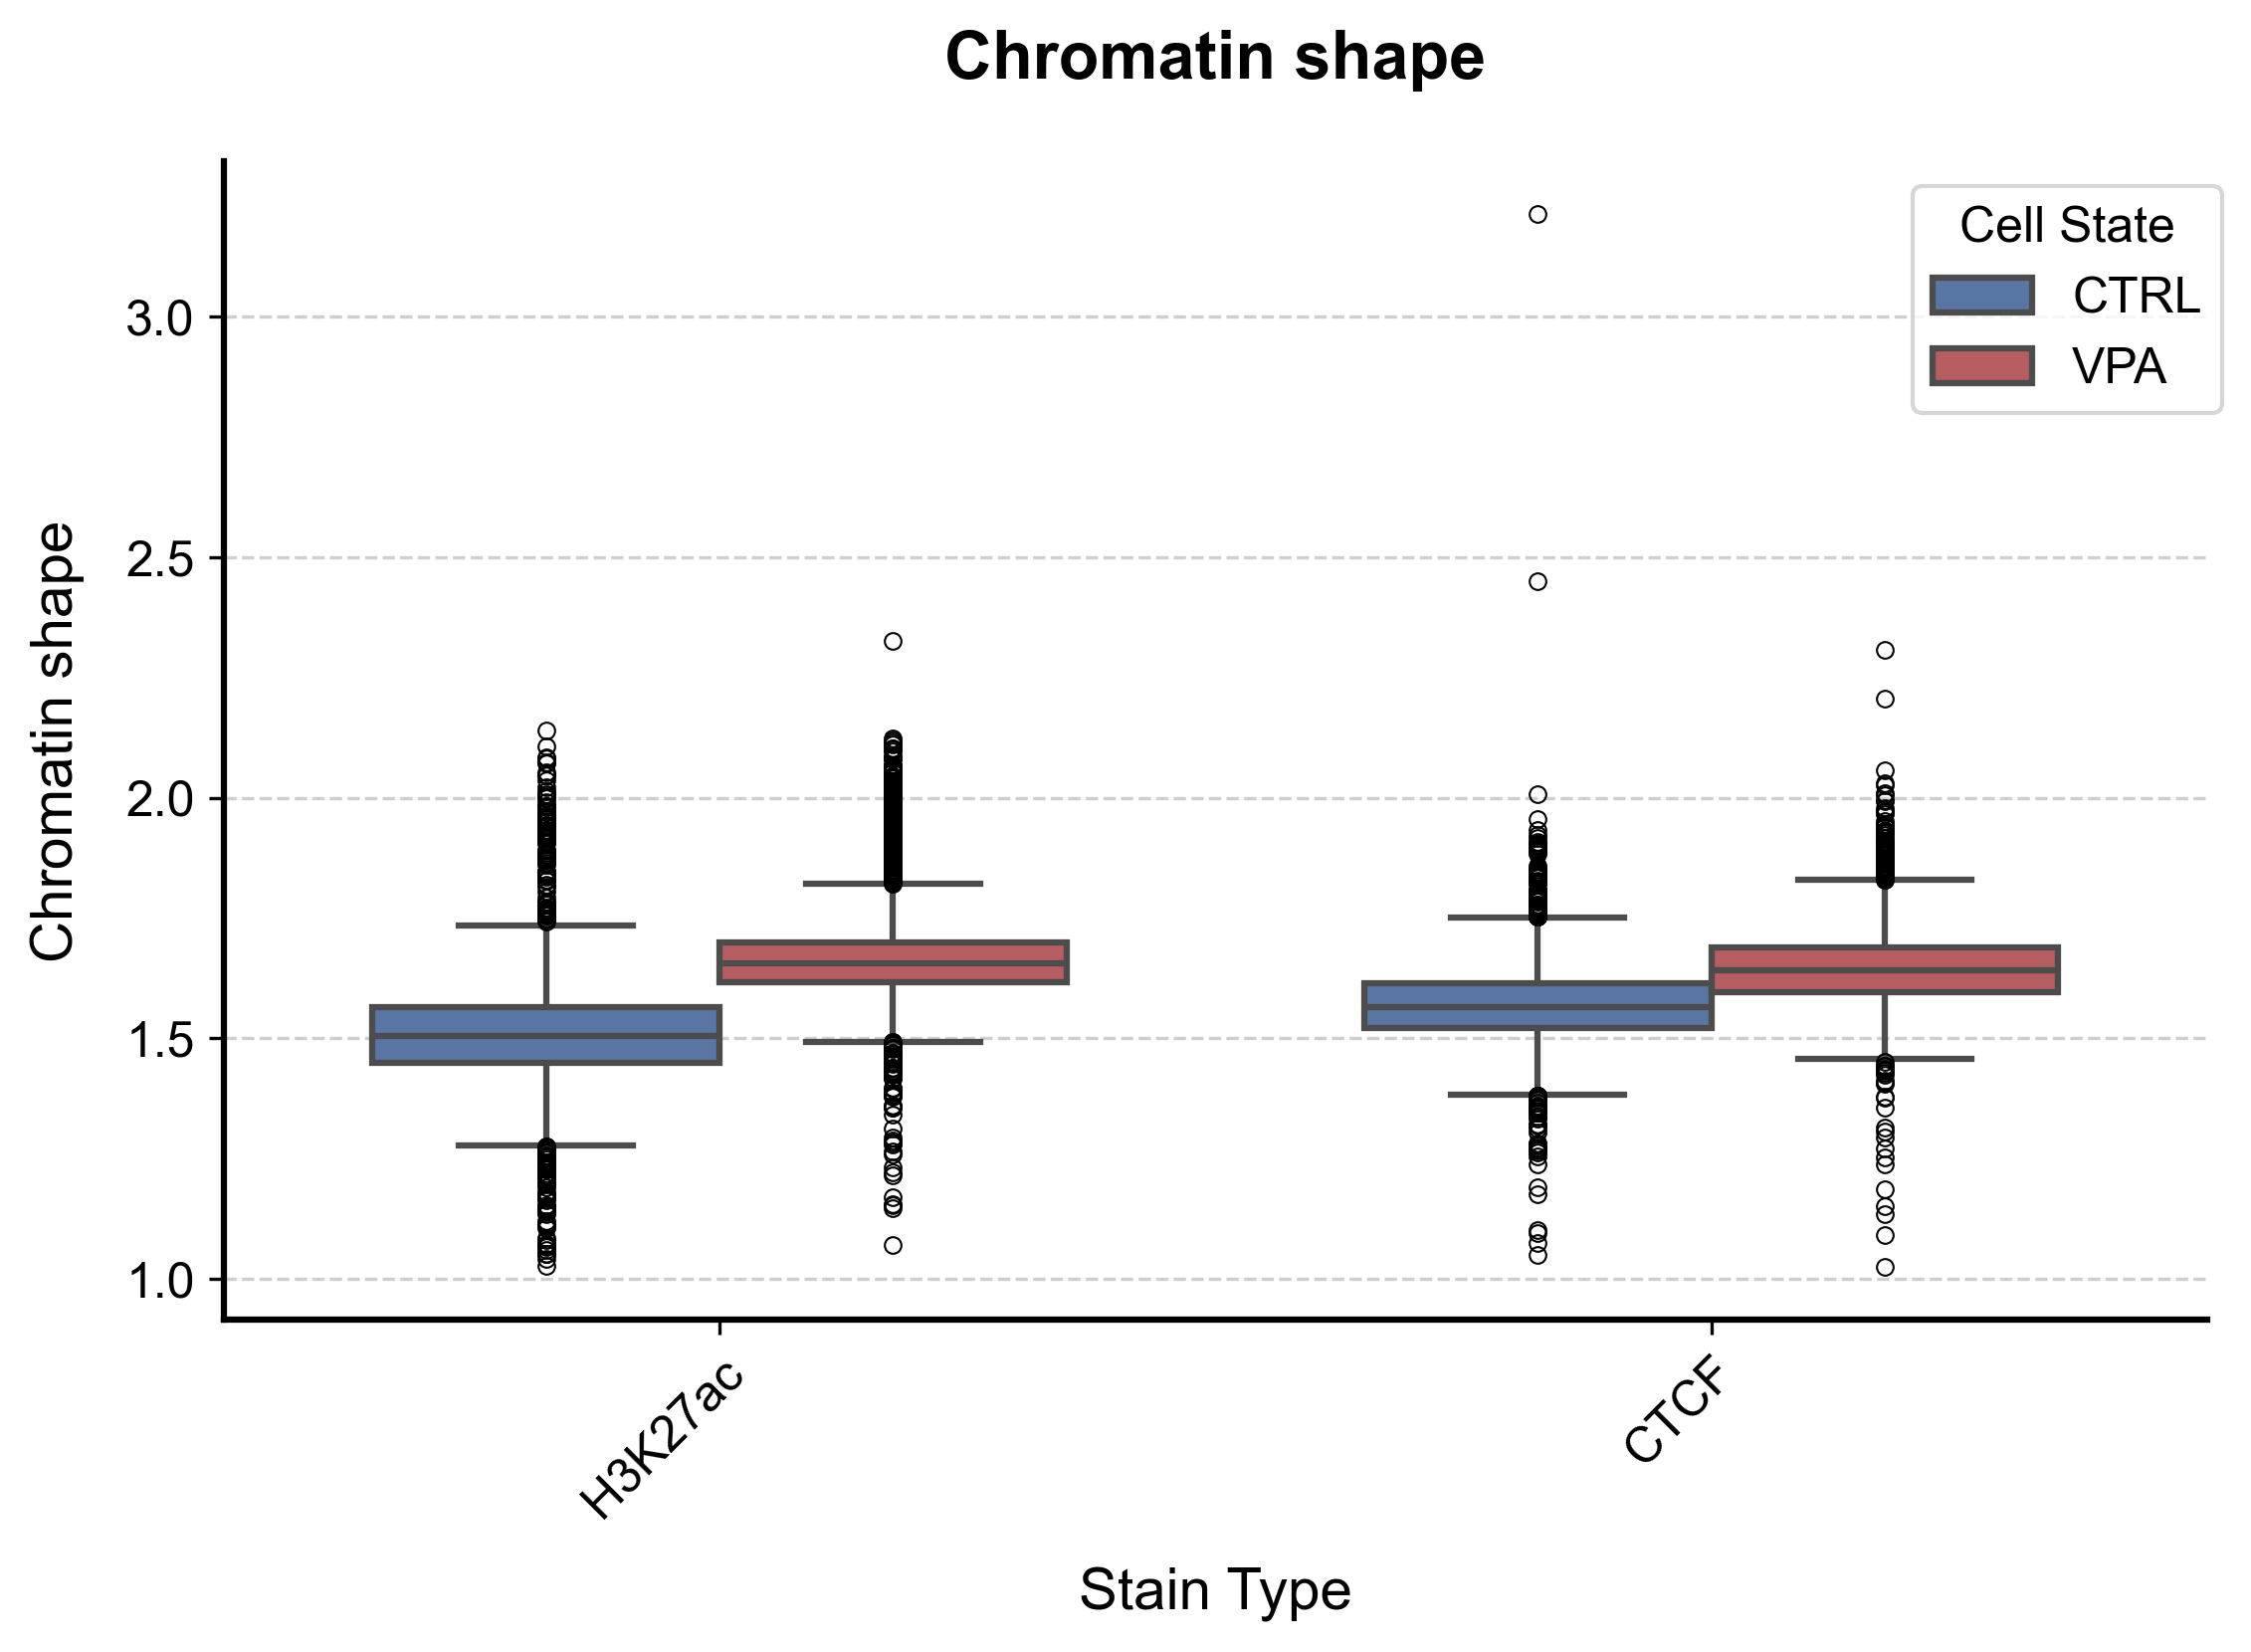

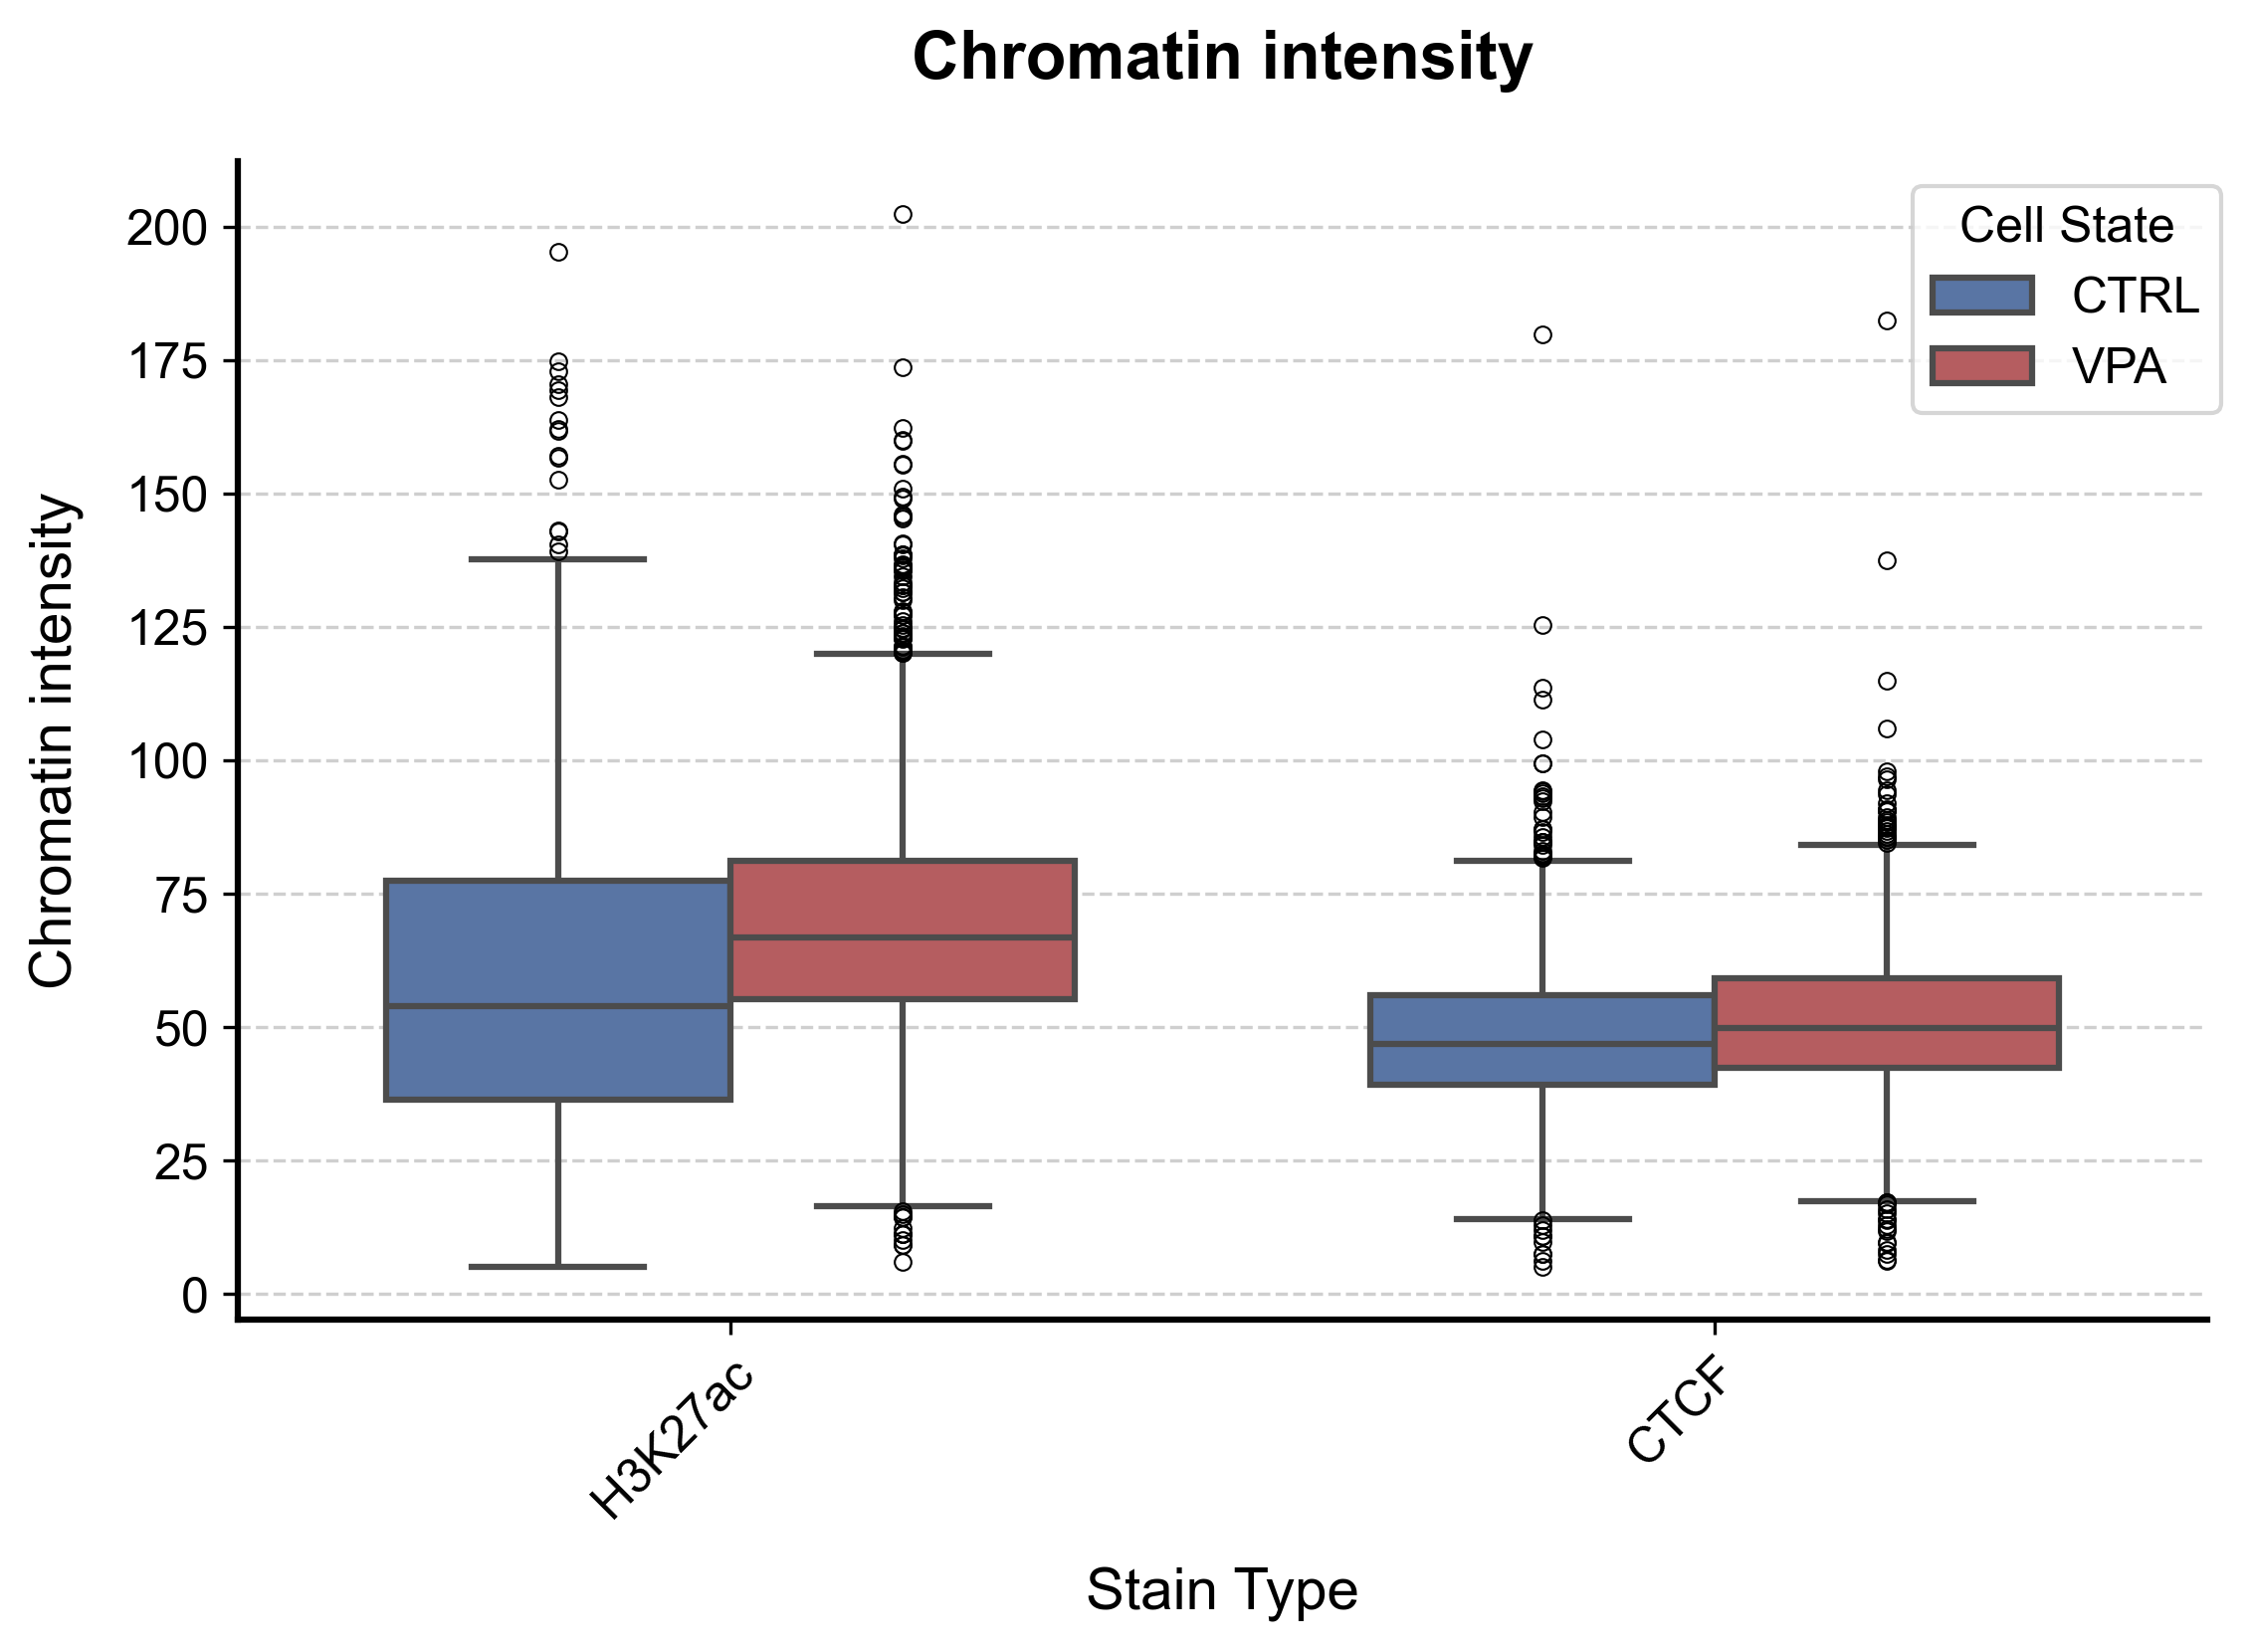

In [94]:
savepath = f"{homepath}/results_VPA/Biomarker/results_figures"

title={'chromatin_num':  'Chromatin number',
       'chromatin_area': 'Chromatin area',
       'chromatin_shape':'Chromatin shape',
       'chromatin_intensity':'Chromatin intensity',
      }

for feature in ['chromatin_num', 'chromatin_area', 'chromatin_shape', 'chromatin_intensity']:
    validata_boxplot(data_all, feature, savepath, rett="VPA")

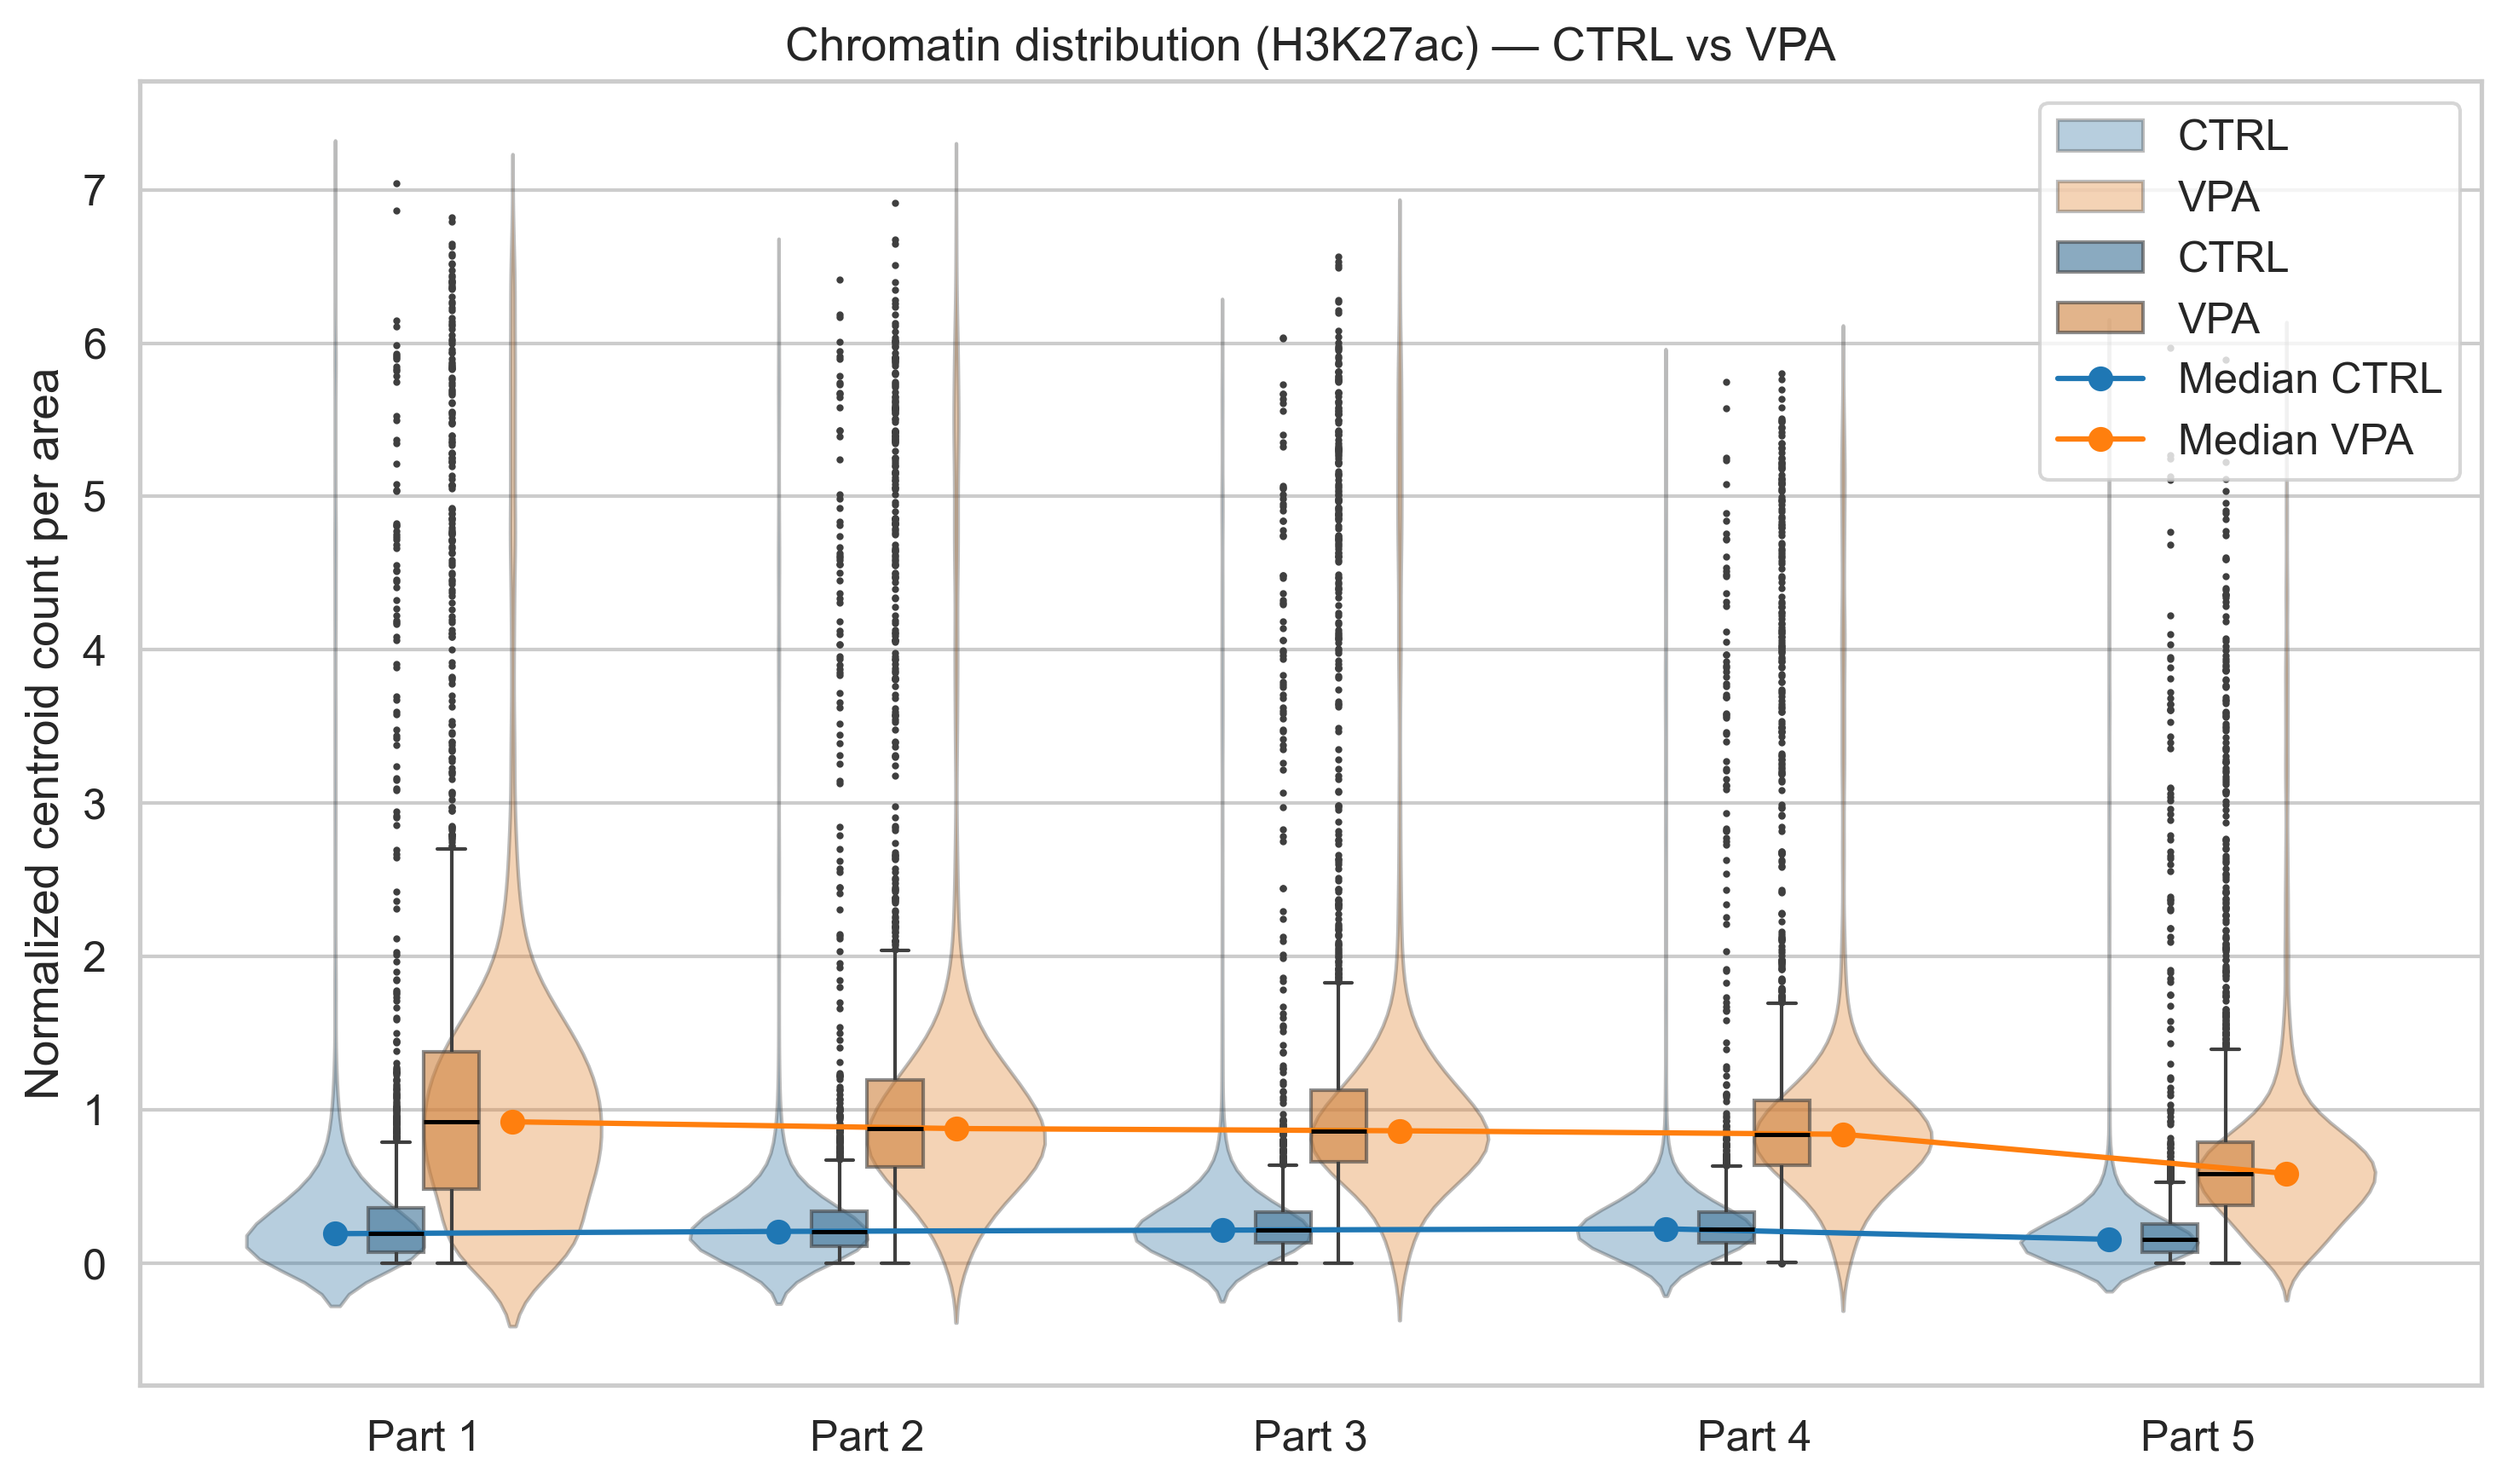

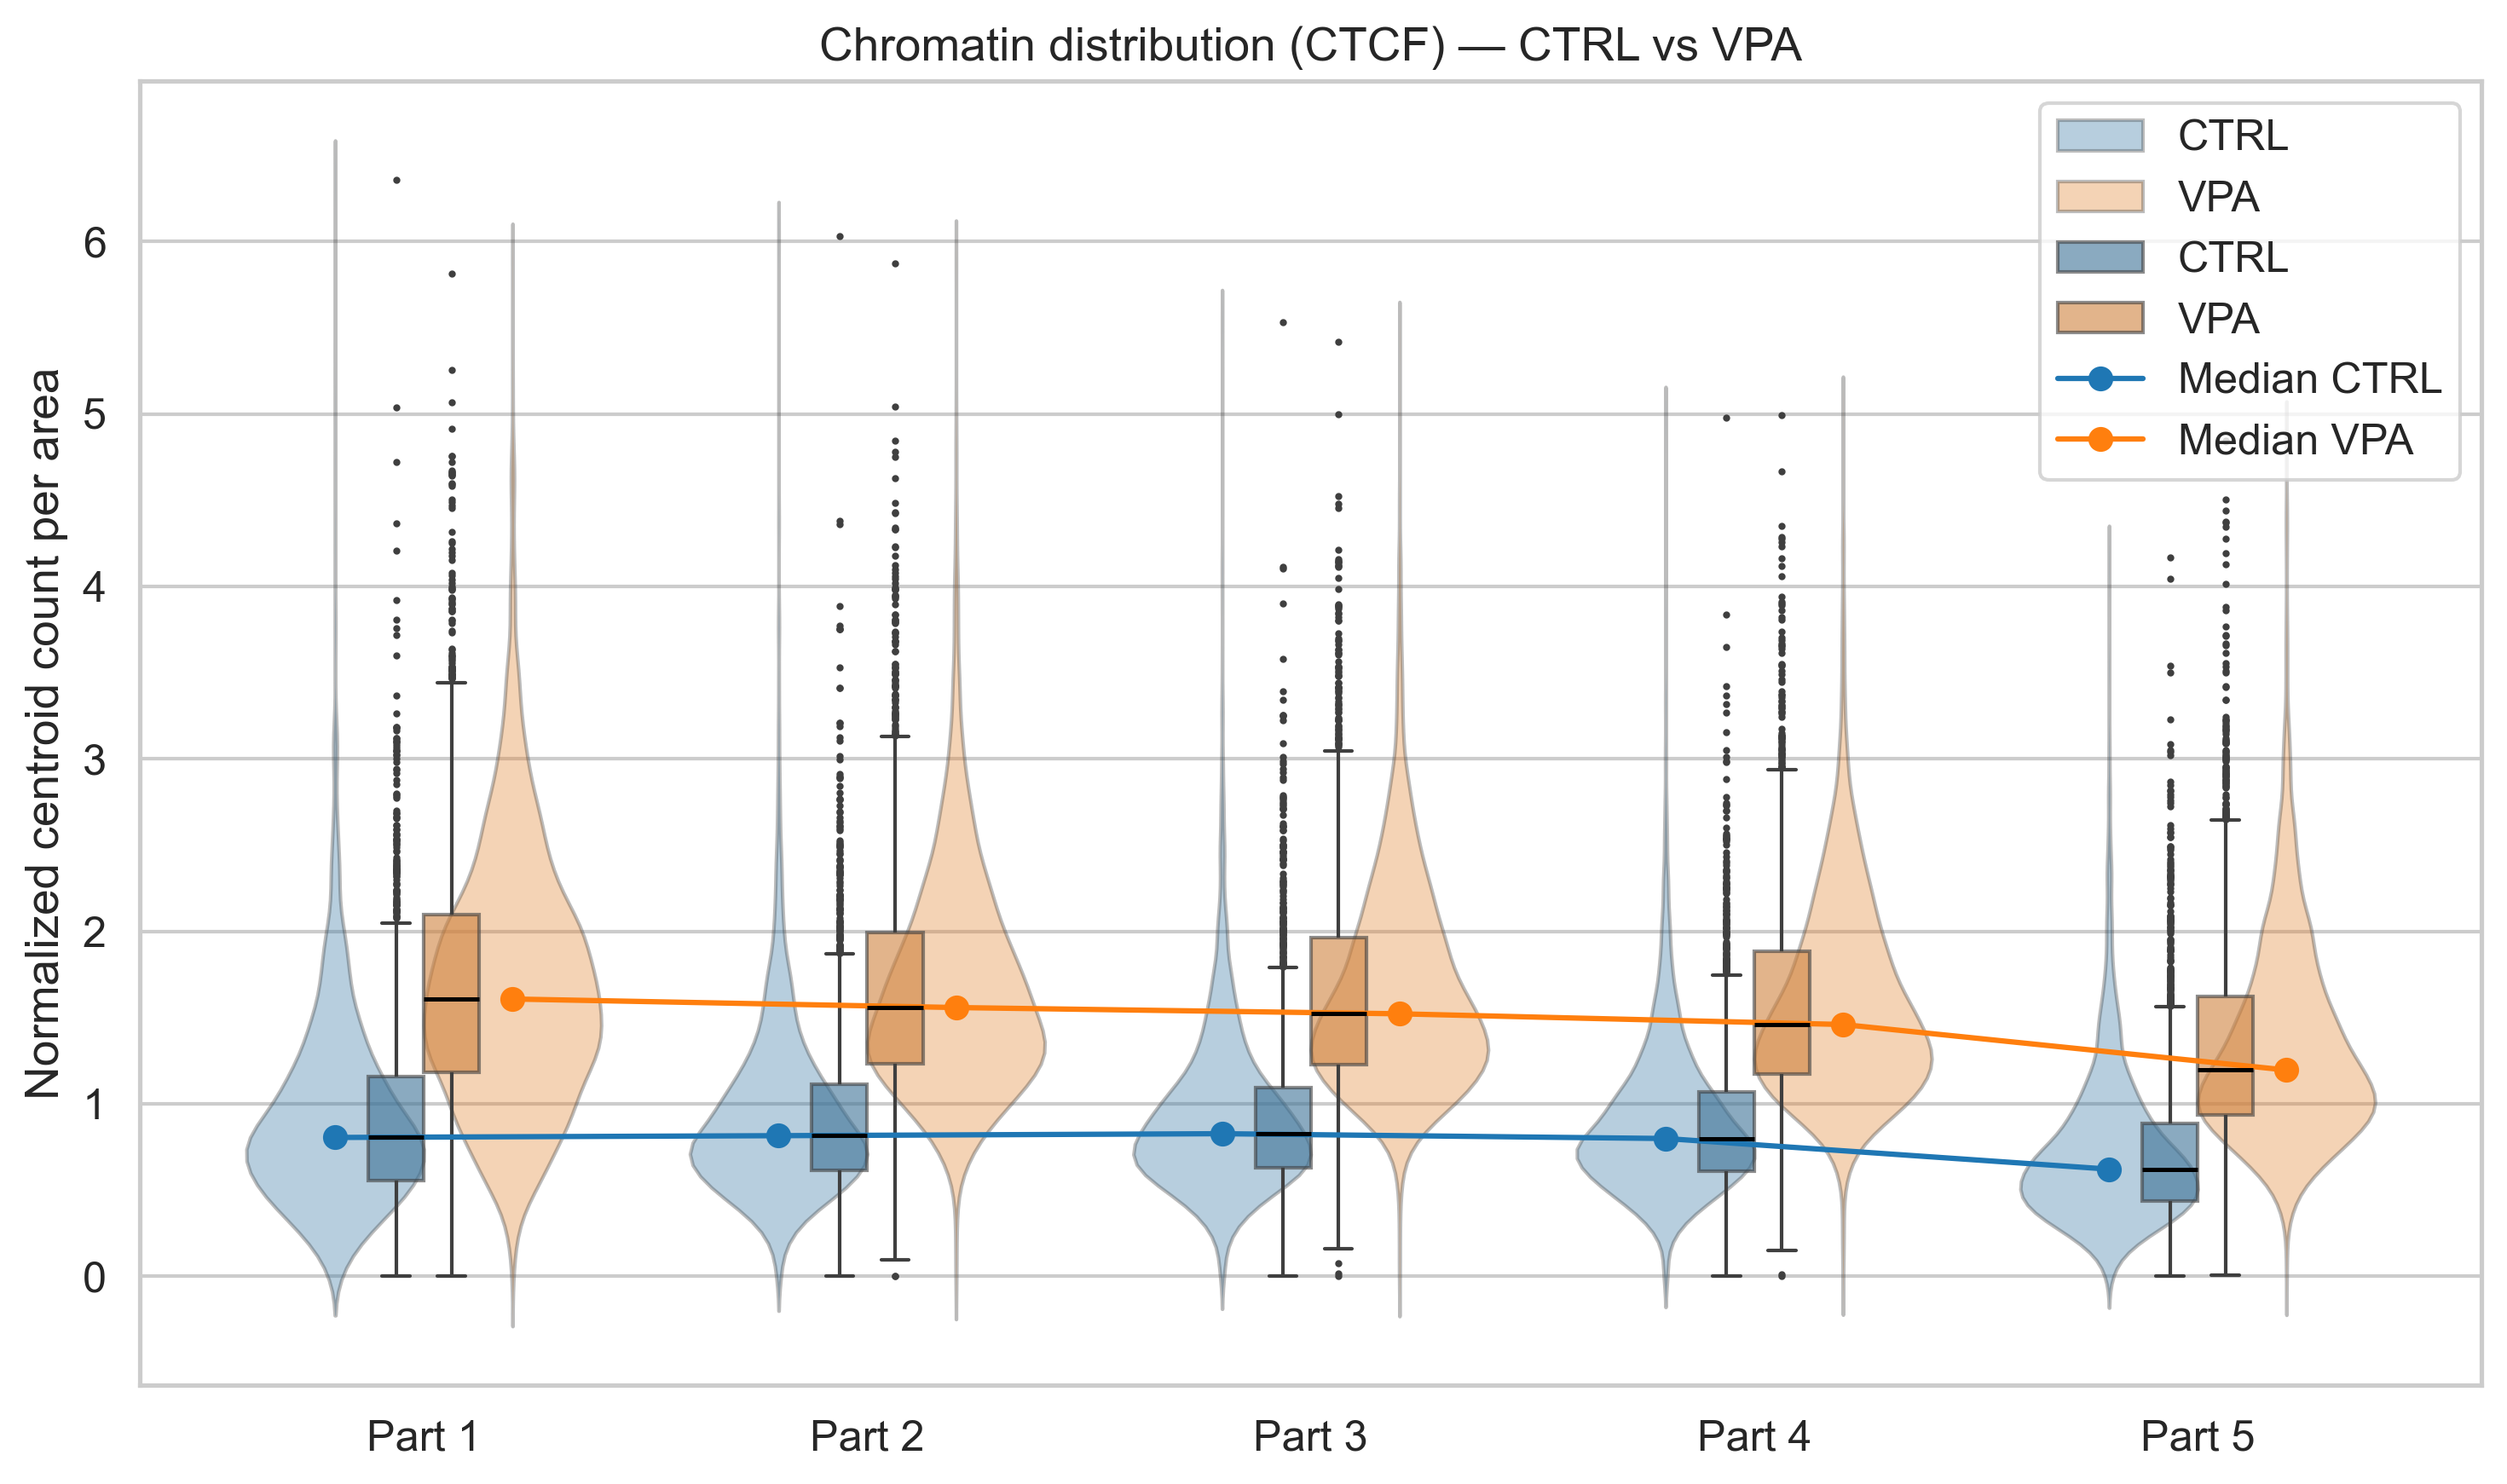

In [95]:
chromatin_distribution_plot(data_all, "H3K27ac", savepath, rett="VPA")
chromatin_distribution_plot(data_all, "CTCF", savepath, rett="VPA")

In [9]:
import numpy as np

original_resolution = 50  # nm/px
sigma = (11 - 1) / 6
effective_resolution = np.sqrt((sigma * original_resolution)**2 + original_resolution**2)

print(f"Effective resolution after Gaussian blur: {effective_resolution:.2f} nm/px")

Effective resolution after Gaussian blur: 97.18 nm/px
